In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

pd.options.display.max_columns = 200
pd.options.display.max_rows = 250

from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,  StratifiedKFold, GridSearchCV
from sklearn.feature_extraction import FeatureHasher
import category_encoders as ce

from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


### Первичный анализ данных

Загрузим данные.

In [ ]:
data_train = pd.read_csv('orange_small_churn_train_data.csv', index_col = 'ID') 
data_test = pd.read_csv('orange_small_churn_test_data.csv',index_col = 'ID')

data_train.head()

In [3]:
data_train.labels.tail()

ID
18294   -1.0
18295    1.0
18296   -1.0
18297   -1.0
18298    NaN
Name: labels, dtype: float64

На последнем объекте тренировочной выборки отстуствует метка, убираем его. Разделим тренировочную и тестовую выборку на вещественную и категориальную части, отделим столбец меток.

In [38]:
data_train_num = data_train.iloc [:-1, :190]
data_train_cat = data_train.iloc[:-1, 190:-1]

data_test_num = data_test.iloc [:, :190]
data_test_cat = data_test.iloc[:, 190:]

In [39]:
target = data_train.labels[:-1]

In [6]:
print 'churn portion {}, \nnot-churn portion {}'.format(np.sum(target == 1) /float(len(target))
                                                        , np.sum(target == -1) /float(len(target)))

churn portion 0.075254126134, 
not-churn portion 0.924745873866


В данных присутствует дисбаланс классов. Смотрим пропуски

In [21]:
 data_train.isnull().sum() 

Var1      18038
Var2      17831
Var3      17832
Var4      17736
Var5      17799
Var6       1991
Var7       1976
Var8      18299
Var9      18038
Var10     17799
Var11     17832
Var12     18085
Var13      1976
Var14     17832
Var15     18299
Var16     17799
Var17     17736
Var18     17736
Var19     17736
Var20     18299
Var21      1991
Var22      1792
Var23     17799
Var24      2616
Var25      1792
Var26     17799
Var27     17799
Var28      1793
Var29     18038
Var30     18038
Var31     18299
Var32     18299
Var33     18010
Var34     17831
Var35      1792
Var36     17831
Var37     17736
Var38      1792
Var39     18299
Var40     17831
Var41     18038
Var42     18299
Var43     17831
Var44      1792
Var45     18171
Var46     17831
Var47     18038
Var48     18299
Var49     17831
Var50     18038
Var51     16888
Var52     18299
Var53     18038
Var54     17831
Var55     18299
Var56     18055
Var57         0
Var58     18038
Var59     17990
Var60     17799
Var61     18010
Var62     18085
Var63   

Пропусков много. В некоторых столбцах пропущены все значения. Чтобы посчитать корреляцию вещественных признаков надо привести данные к одному масштабу.

In [40]:
X_num_scaled = MinMaxScaler().fit_transform(data_train_num)
data_train_num_scaled = pd.DataFrame(X_num_scaled, columns=data_train_num.columns)
data_train_num_scaled.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190
count,261.000000,468.000000,467.000000,563.000000,500.000000,16307.000000,16322.000000,0.0,261.000000,500.000000,467.000000,214.000000,16322.000000,467.000000,0.0,500.000000,563.000000,563.000000,563.000000,0.0,16307.000000,16506.000000,500.000000,15682.000000,16506.000000,500.000000,500.000000,16505.000000,261.000000,261.000000,0.0,0.0,289.000000,468.000000,16506.000000,468.000000,563.000000,16506.000000,0.0,468.000000,261.000000,0.0,468.000000,16506.000000,128.000000,468.000000,261.000000,0.0,468.000000,261.000000,1411.000000,0.0,261.000000,468.000000,0.0,244.000000,18298.000000,261.000000,309.000000,500.000000,289.000000,214.000000,258.000000,84.000000,16322.000000,258.000000,500.0,468.000000,500.000000,500.000000,388.000000,10136.000000,18298.000000,16322.000000,468.000000,16506.000000,261.000000,16506.000000,0.0,500.000000,16307.000000,563.000000,16506.000000,467.000000,16506.000000,261.000000,261.000000,377.000000,244.000000,261.000000,388.000000,52.000000,500.000000,10136.000000,468.000000,468.000000,500.000000,214.000000,563.000000,261.000000,290.000000,142.000000,500.000000,309.000000,309.000000,563.000000,500.000000,261.000000,15682.000000,261.000000,388.000000,16506.000000,18298.000000,468.000000,309.000000,261.000000,563.000000,52.0,16307.000000,500.000000,261.000000,468.000000,16506.000000,563.000000,16322.000000,13255.000000,377.000000,377.000000,261.000000,467.000000,261.000000,16506.000000,16506.000000,16506.000000,563.000000,258.000000,261.000000,563.000000,500.000000,16322.000000,0.0,261.000000,16506.000000,16307.000000,563.000000,500.000000,500.000000,500.000000,15682.000000,563.000000,289.000000,563.000000,16506.000000,261.000000,563.000000,258.000000,388.000000,290.000000,468.000000,16506.000000,563.000000,468.000000,16506.000000,563.000000,290.000000,500.000000,0.0,261.000000,0.0,468.000000,377.000000,500.000000,16506.000000,563.000000,0.0,467.000000,468.000000,244.000000,563.000000,261.000000,16506.000000,563.000000,468.000000,468.000000,0.0,261.000000,261.000000,468.000000,7681.000000,104.000000
mean,0.027524,0.002137,0.004548,0.008881,0.045701,0.011431,0.194033,NaN,0.022186,0.065449,0.023555,0.015061,0.015327,0.021949,NaN,0.276710,0.041783,0.020968,0.008289,NaN,0.006505,0.006435,0.041923,0.009198,0.007309,0.010000,0.010000,0.138442,0.003831,0.107535,NaN,NaN,0.045534,0.020757,0.018092,0.075799,0.053619,0.141606,NaN,0.042869,0.038885,NaN,0.030206,0.004604,0.120010,0.012459,0.017150,NaN,0.007479,0.028385,0.125479,NaN,0.063605,0.153312,NaN,0.040238,0.500718,0.023071,0.082279,0.036508,0.091036,0.013637,0.015598,0.150313,0.050352,0.022299,0.0,0.015678,0.188502,0.064141,0.043643,0.057461,0.241200,0.003694,0.091728,0.077533,0.017845,0.013459,NaN,0.026747,0.056832,0.270574,0.003231,0.012312,0.007255,0.136340,0.2

In [41]:
# найдем индексы объектов отток - не-отток
churn_indices = target[target == 1].index 
nchurn_indices =target[target == -1].index 
# делим 'вещественную' подвыборку по классам
data_train_num_scaled_churn = data_train_num_scaled.iloc[churn_indices]
data_train_num_scaled_nchurn = data_train_num_scaled.iloc[nchurn_indices]

In [42]:
# считаем корреляцию вещественных признаков 
num_corr = []
for n in data_train_num_scaled.columns:
    num_corr.append([n, data_train_num_scaled_churn[n].mean() - data_train_num_scaled_nchurn[n].mean(),  np.abs(data_train_num_scaled_churn[n].mean() - data_train_num_scaled_nchurn[n].mean())])
num_corr_df = pd.DataFrame.from_records(num_corr)
num_corr_df.columns = ['var', 'corr', 'abs_corr']

In [43]:
# сортируем по убыванию модуля коэффициента
num_corr_df.sort_values('abs_corr', ascending = False)

,var,corr,abs_corr
129,Var130,0.152349,0.152349
110,Var111,0.136040,0.136040
138,Var139,0.120787,0.120787
179,Var180,0.111709,0.111709
167,Var168,-0.108185,0.108185
68,Var69,0.102665,0.102665
176,Var177,0.098088,0.098088
9,Var10,0.094828,0.094828
187,Var188,0.089339,0.089339
113,Var114,0.086338,0.086338


Да, в самых коррелирующих вещественных признаках много пропусков. Посмотрим корреляцию  категориальных признаков с целевой переменной.

In [8]:
#функция для подсчета корреляции категориальных признаков
def cramers_v_stat(confusion_matrix):
    """Calculate Cramérs V statistic for categorial-categorial association."""
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((r-1), (k-1)))

In [34]:
data_train_cat.head()

,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NESt0G8EIb,AERks4l,NaN,taul,1K8T,0LaQ,UaKK0yW,I1sFbv_0IT,NaN,NaN,EkHG,9_Y1,k13i,09_Q,IYzP,GjJ35utlTa_GNSvxxpb9ju,kIsH,NaN,uKAI,L84s,JBfYVit4g8,NaN,NaN,NaN,TDctq2l,KmRo,cJvF,FzaX,hLKtJ9p,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,P1WvyxLp3Z,2Knk1KF,NaN,taul,1K8T,YFAj,Bnunsla,o64y9zI,DlISMzi,NaN,JDd6,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,I_mbgcr,NaN,XTbqizz,qMoY,cJvF,FzaX,hN8KpA1,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,FoxgUHSK8h,LrdZy8QqgUfkVShG,NaN,taul,1K8T,TyGl,fhk21Ss,nQUveAzAF7,NaN,NaN,dnwD,9_Y1,mTeA,VpdQ,hAFG,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,4kVnq_T26xq1p,NaN,NaN,NaN,pMWBUmQ,qLXr,UYBR,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,vNEvyxLp3Z,RO12,NaN,taul,1K8T,0Xwj,uoZk2Zj,LWyxgtXeJL,NaN,NaN,CwmB,F3hy,vzJD,VpdQ,IYzP,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJtVhC,JC0e,cJvF,FzaX,ylCK5YS,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,4e7gUH7IEC,RO12,NaN,taul,1K8T,vSNn,kugYdIL,ZIXKpoNpqq,NaN,NaN,625Z,9_Y1,m_h1,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,NGZXfGp,064o,cJvF,FzaX,PYpzAu9,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN


In [17]:
#считаем корреляцию с целевой переменной

cat_corr = []
var_columnn = 0
for c in data_train_cat.columns:
    # при подсчете заменим пропуски на 'NA', все значения переведем в строки
    var_column = data_train_cat[c].copy(deep=True)
    var_column.fillna('NA', inplace=True)
    var_column = var_column.astype(str)
    
    cont_table = pd.crosstab(var_column,target)
    cat_corr.append([c, cramers_v_stat(cont_table.values), var_column.nunique() ])
cat_corr_df = pd.DataFrame.from_records(cat_corr)
cat_corr_df.columns = ['var', 'corr', 'n_unique']

# выводим список категориальных признаков, отсортированных по убыванию корреляциии, значения коэффициента
# а ещё - число категорий
cat_corr_df.sort_values('corr', ascending = False)

,var,corr,n_unique
26,Var217,0.628110,7944
23,Var214,0.574564,7414
9,Var200,0.574564,7414
11,Var202,0.491060,4673
8,Var199,0.466439,2639
31,Var222,0.358400,2721
29,Var220,0.358400,2721
7,Var198,0.358400,2721
25,Var216,0.281255,1247
1,Var192,0.192722,326


Визуализируем распределения для числовых переменных, наиболее сильно коррелирующих с целевой функцией

In [14]:
# топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией
top20_num_var = num_corr_df.sort_values('abs_corr', ascending = False) ['var'][:20].to_list()

print top20_num_var

['Var130', 'Var111', 'Var139', 'Var180', 'Var168', 'Var69', 'Var177', 'Var10', 'Var188', 'Var114', 'Var64', 'Var189', 'Var53', 'Var73', 'Var45', 'Var86', 'Var131', 'Var54', 'Var147', 'Var7']


In [44]:
# функция для отрисовки гистограмм вещественных признаков 
def features_hist_classes (data, names):
    fig, axes = plt.subplots(nrows=len(names)/2, ncols=4, figsize=(16, len(names)/2*3.5))
    plot_number = 0
    for feature_name in names:
    
        plot_number += 1
        plt.subplot(len(names)/2, 4, plot_number)
        plt.hist( data.loc[data.target==1, feature_name].dropna(), color="r", label = 'churn')
        plt.legend()
        plt.xlabel(feature_name)
    
        plot_number += 1
        plt.subplot(len(names)/2, 4, plot_number)
        plt.hist( data.loc[data.target==-1, feature_name].dropna() , color="b", label = 'not_churn')
        plt.legend()
        plt.xlabel(feature_name)

In [45]:
# в данных много выбросов, для наглядности логарифмируем данные: log(1+x)
# добавим столбец target и нарисуем гистограммы топ-30 числовых признаков, наиболее коррелирующих с меткой 
#(т.к. в top-20 много пропусков)
data_train_num_scaled_log = data_train_num_scaled.copy(deep = True)
top30_num_var = num_corr_df.sort_values('abs_corr', ascending = False) ['var'][:30].to_list()
for lc in top30_num_var:
    data_train_num_scaled_log[lc].apply(lambda x: np.log1p(x))


In [60]:
# функция для отрисовки гистограмм вещественных признаков 
def features_hist_classes_3 (data, names):
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
    plot_number = 0
    for feature_name in names:
    
        plot_number += 1
        plt.subplot(3, 2, plot_number)
        plt.hist( data.loc[data.target==1, feature_name].dropna(), color="r", label = 'churn')
        plt.legend()
        plt.xlabel(feature_name)
    
        plot_number += 1
        plt.subplot(3, 2, plot_number)
        plt.hist( data.loc[data.target==-1, feature_name].dropna() , color="b", label = 'not_churn')
        plt.legend()
        plt.xlabel(feature_name)
        #plt.show()

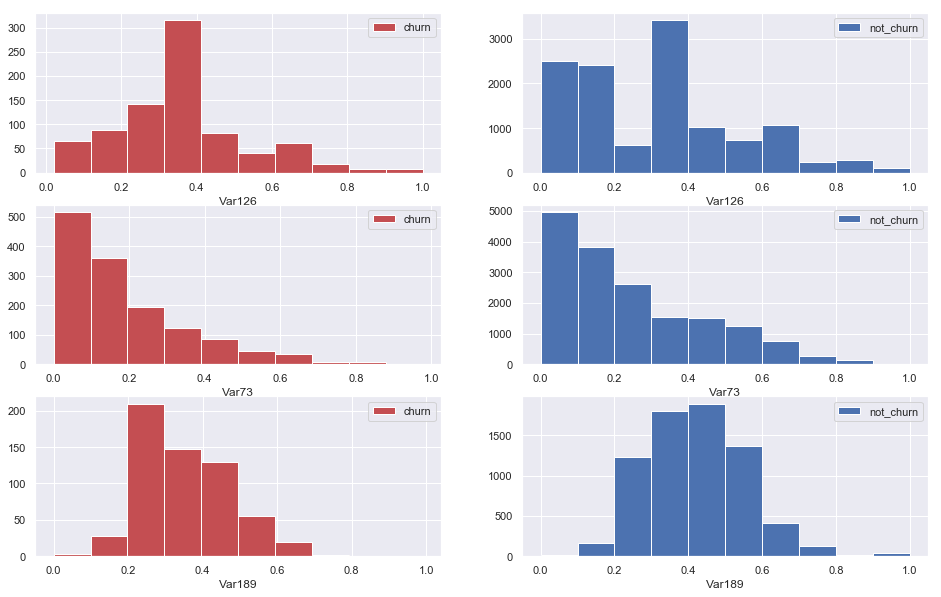

In [61]:
data_train_num_scaled_log['target'] =-1
data_train_num_scaled_log['target'].iloc[churn_indices]=1
sns.set(font_scale = 1.0)
features_hist_classes_3 (data_train_num_scaled_log,['Var126','Var73','Var189'])

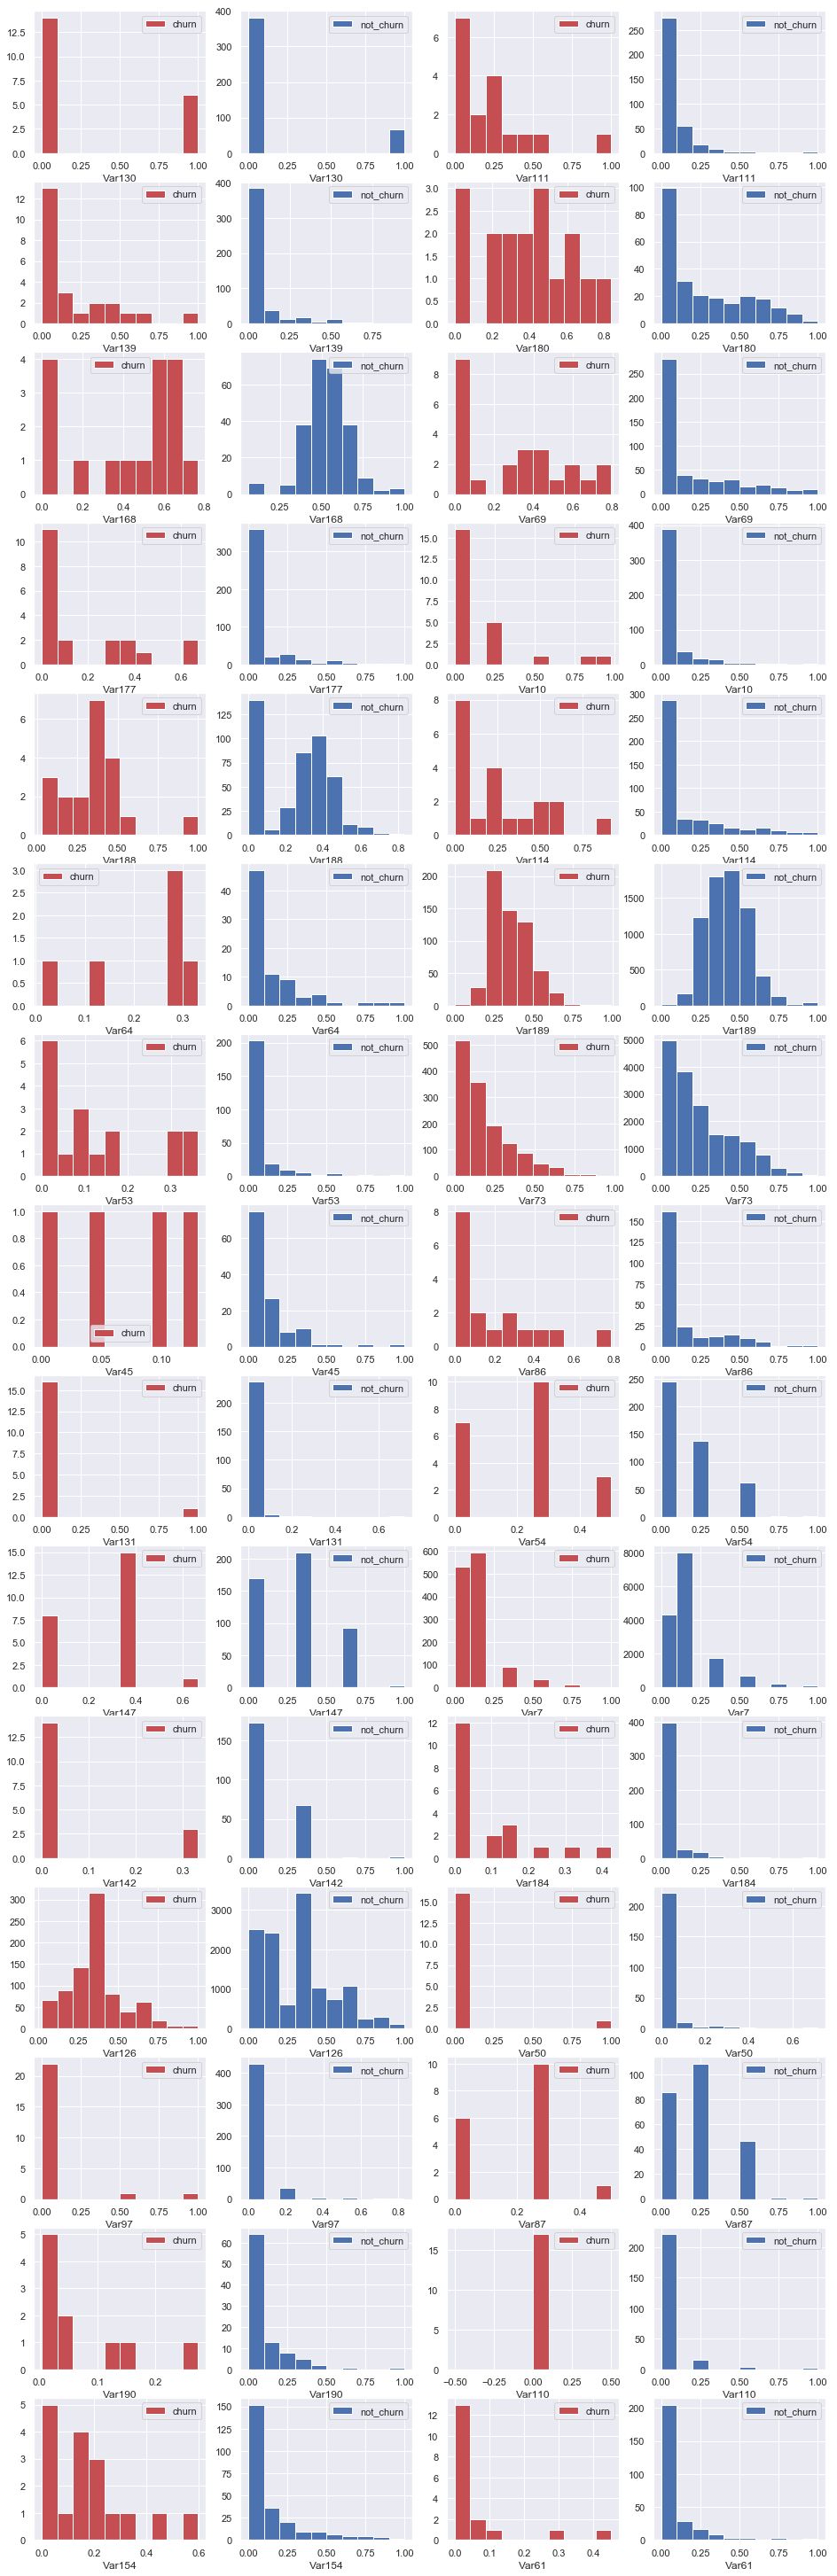

In [60]:
data_train_num_scaled_log['target'] =-1
data_train_num_scaled_log['target'].iloc[churn_indices]=1
sns.set(font_scale = 1.0)
features_hist_classes (data_train_num_scaled_log,top30_num_var)

Распределения для разных классов отличаются (и они редко где похожи на нормальное), но полезных данных мало - много пропусков. Скорее всего, наиболее полезными окажутся вещественные признаки из top-30, которые имеют и наибольшую корреляцию,  и мало пропущенных значений: 189, 73, 7, 126.
Для порядка посмотрим sns.pairplot для top-20.

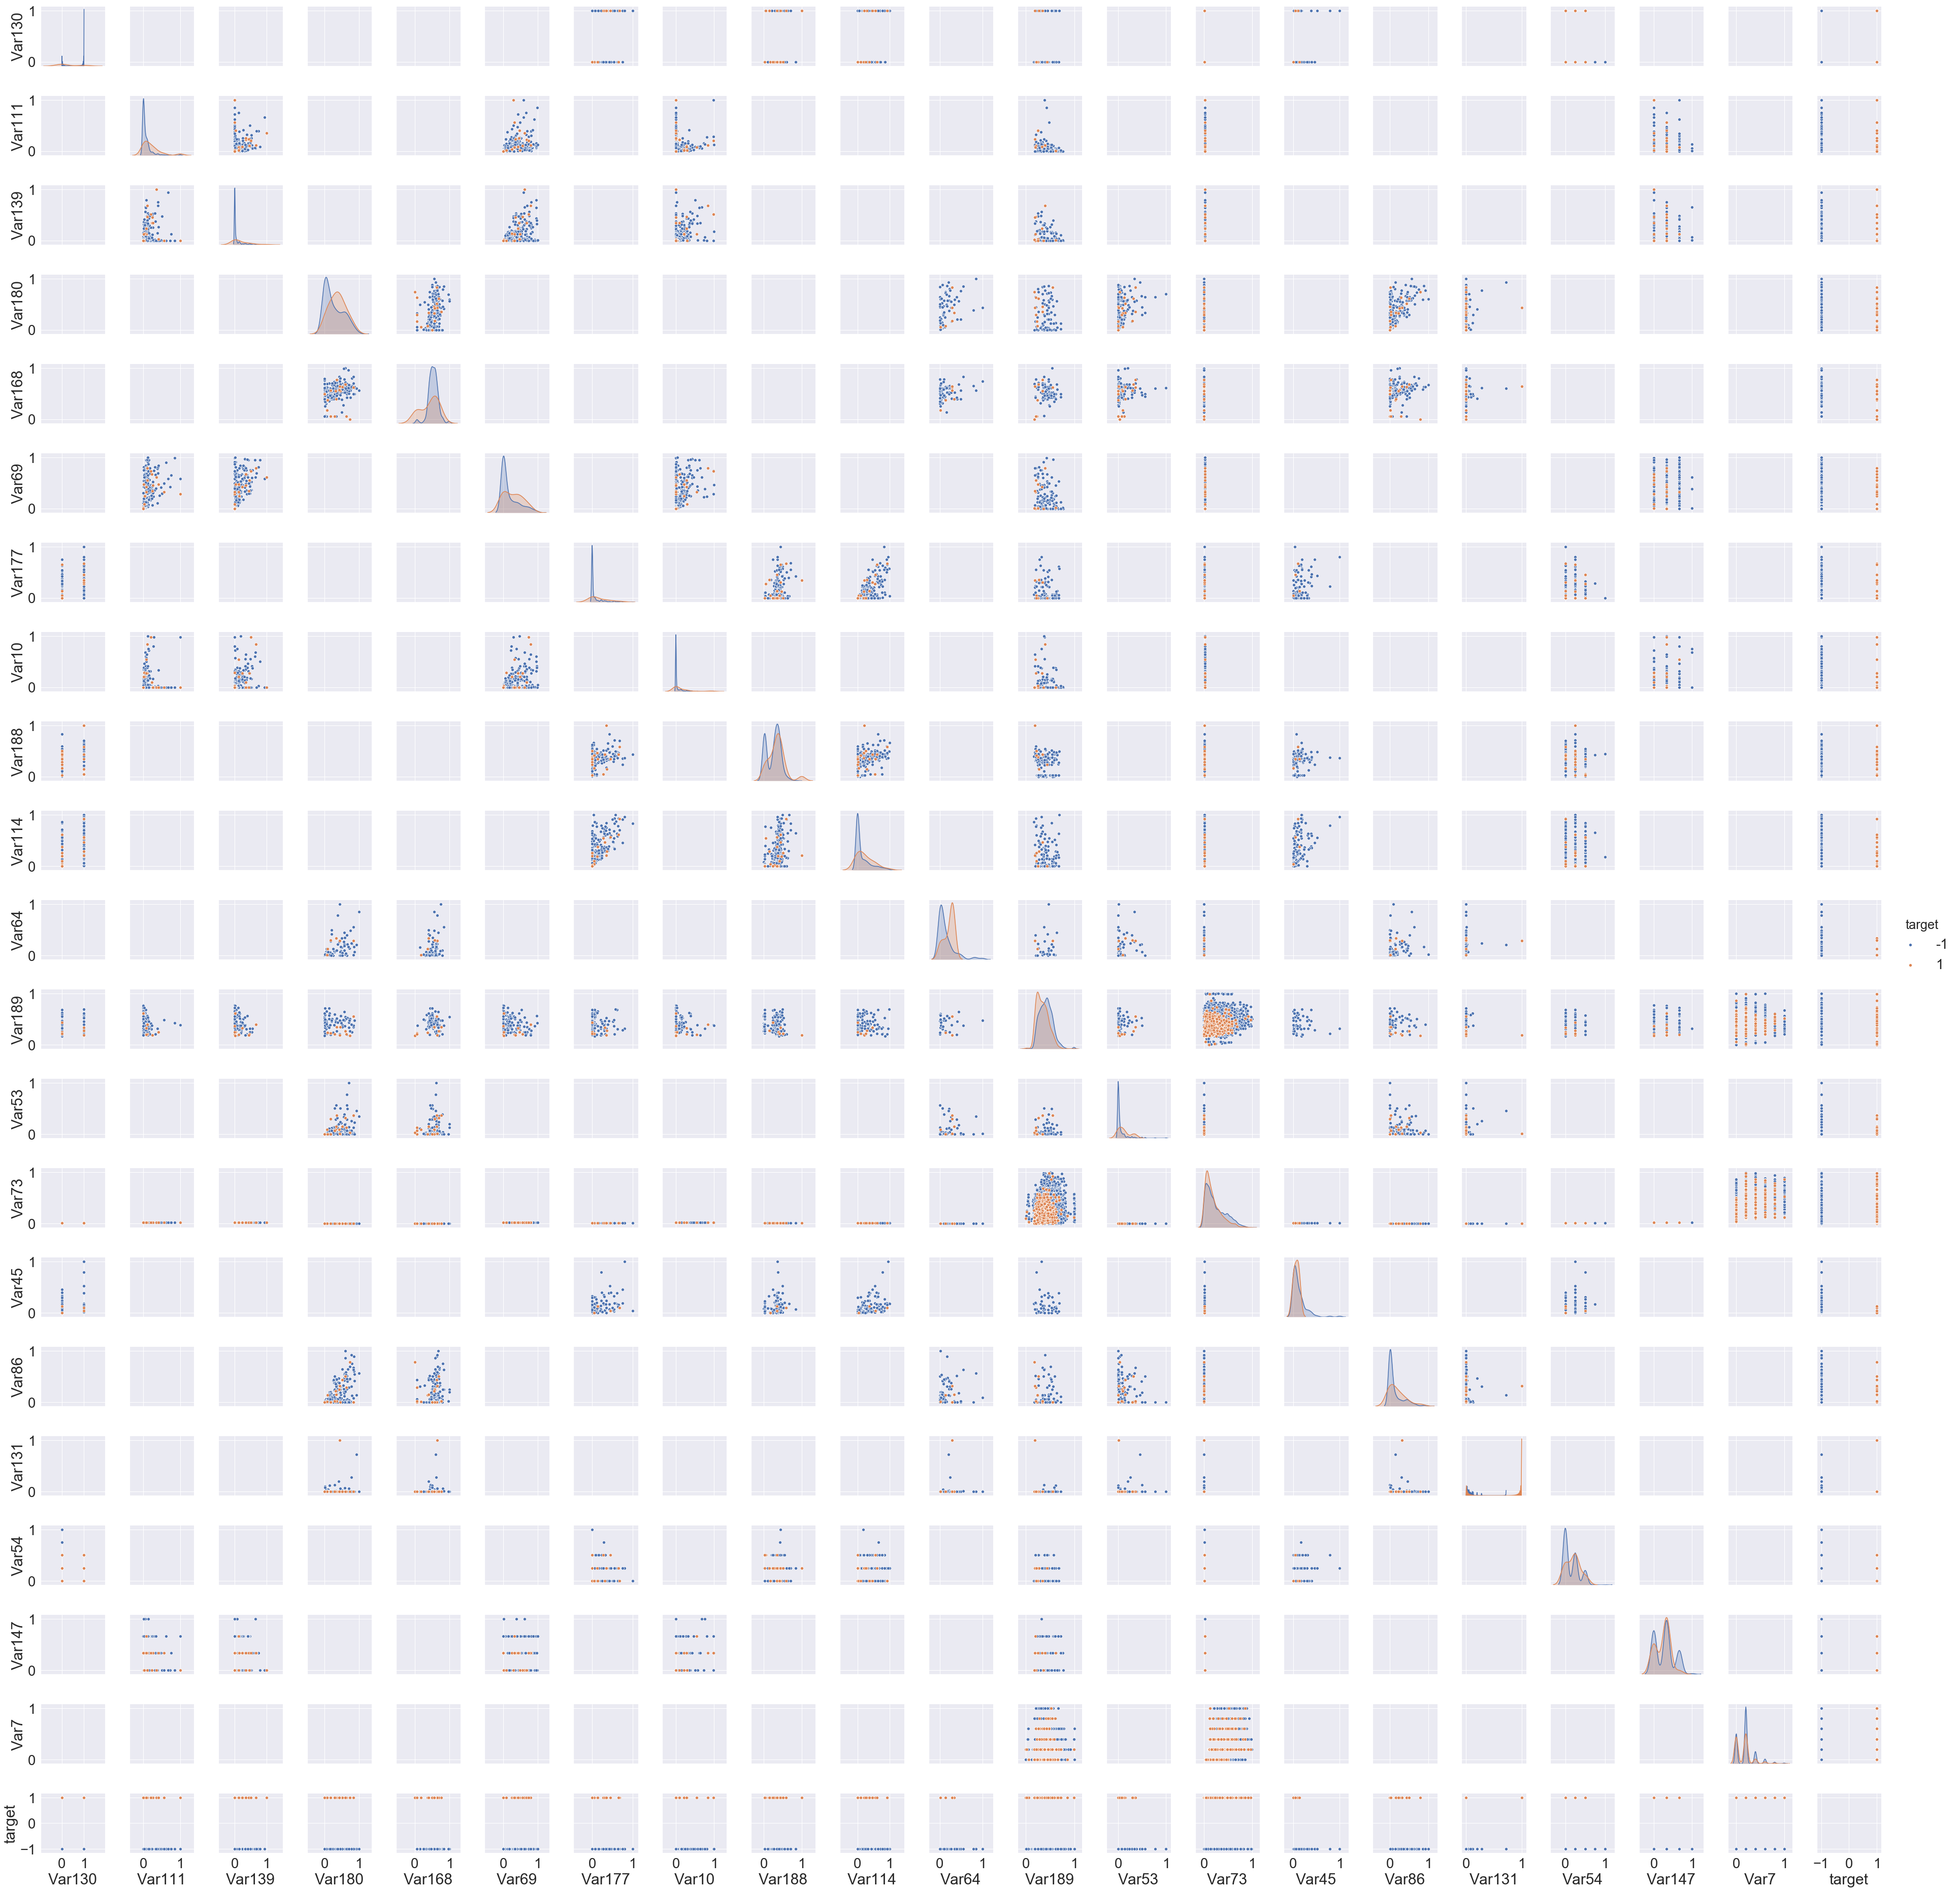

In [55]:
top20_num_var_target =[]
top20_num_var_target = top20_num_var
top20_num_var_target.append('target')
sns.set(font_scale = 2.5)
sns.pairplot(data_train_num_scaled_log [top20_num_var_target], hue = 'target')

Опять же, из-за пропущенных данных мы видим много пустых графиков. Видим, что данные не очень хорошо разделяются по классам. Кое-где видим присутствует тренд в попарных зависимостях признаков. 

На мой взгляд, здесь строить гистограммы 10 случайных и наименее коррелирующих с целевой переменной признаков не очень целесообразно (и ноутбук станет огромным), поэтому эти пункты пропускаю. 
Построим гистограммы значений категориальных переменных для разных классов, отсортированных в порядке уменьшения корреляции с меткой.

Визуализируем top-20 (на большее не хватает памяти) наиболее коррелирующих с целевой переменной категориальных признаков для каждого класса. 


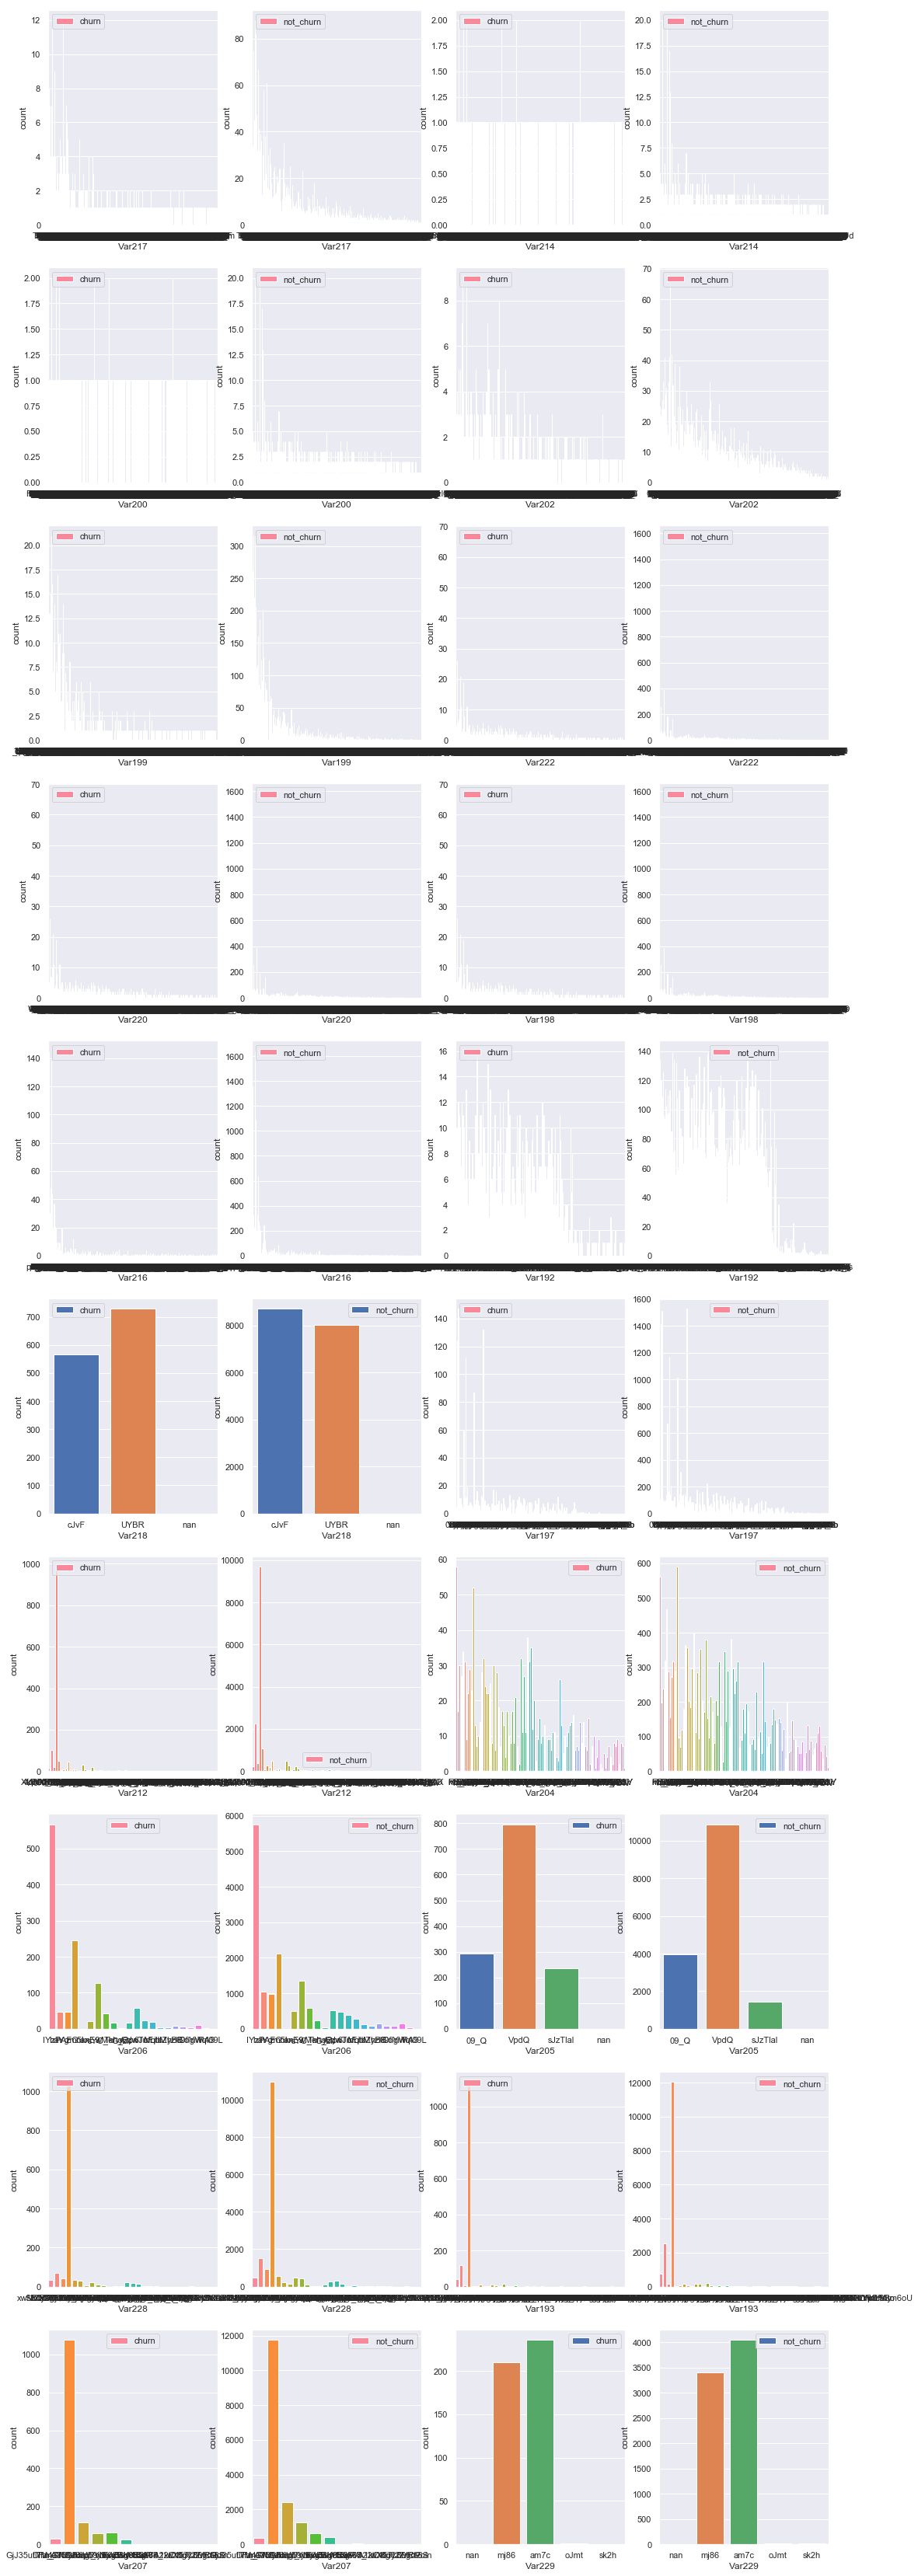

In [12]:
# к 'категориальным' данным добавим столбец 'target'
data_train_cat['target'] =-1
data_train_cat['target'].iloc[churn_indices]=1

#строим гистограммы
sns.set(font_scale = 1.0)
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(18, 60))
plot_number = 0
order = 0
top20_cat_var = list(cat_corr_df.sort_values('corr', ascending = False) ['var'].values)[:20]
for feature_name in top20_cat_var:
    order = list(data_train_cat[feature_name].unique() )
    plot_number += 1
    plt.subplot(10, 4, plot_number)
    sns.countplot(x=feature_name, data=data_train_cat[data_train_cat.target==1], order = order
                  , saturation = 1, label = 'churn')
    plt.legend()
    
    plot_number += 1
    plt.subplot(10, 4, plot_number)
    sns.countplot(x=feature_name, data=data_train_cat[data_train_cat.target==-1], order = order
                  , saturation = 1, label = 'not_churn')
    plt.legend()

In [16]:
data_train_cat.drop('target', axis = 1, inplace = True)

Видим, что в большинстве признаков - много категорий, поэтому нам потребуются способы кодирования, способные адекватно их обработать. Также упомянем, что раз в наиболее коррелирующих с целевой переменной признаках очень много категорий, то возникает вопрос насколько такие признаки будут нам полезны, ведь в выборке мало примеров на одну категорию.

### Предварительная обработка данных

Для начала отделим hold-out выборку для валидации. Полученную тренировочную и hold-out выборки разделим на 'вещественную' и 'категориальные' части.

In [7]:
data_train_train, data_train_valid, y_train_train, y_train_valid = train_test_split(data_train.iloc [:-1,:-1]
                                                      , target, 
                                                      test_size=0.2, 
                                                     random_state=17, stratify=target, shuffle = True)
data_train_train_num = data_train_train.iloc[:,:190]
data_train_train_cat = data_train_train.iloc[:,190:]

data_train_valid_num = data_train_valid.iloc[:,:190]
data_train_valid_cat = data_train_valid.iloc[:,190:]



В качестве модели у нас выбран XGBoostClassifier.
Для начала поищем оптимальную стратегию заполнения пропусков в вещественных признаках - не будем заполнять пропуски, заполним пропущенные значения медианой, средним, константой, равной 0 и -999. Посмотрим качество на кросс-валидации только для вещественных признаков.

In [4]:
#задаем стратегию кросс-валидации
skf = StratifiedKFold(n_splits=4, random_state=17, shuffle = True)

In [56]:
X_median = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(data_train_train_num)
X_mean =  SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(data_train_train_num)
X_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 0.).fit_transform(data_train_train_num)
X_999 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = -999.).fit_transform(data_train_train_num)
print 'roc_auc as is', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train_num ,y_train_train,cv = skf,scoring = 'roc_auc').mean()
print 'roc_auc median', cross_val_score(XGBClassifier(n_jobs = -1),X_median ,y_train_train,cv = skf,scoring = 'roc_auc').mean()
print 'roc_auc mean', cross_val_score(XGBClassifier(n_jobs = -1),X_mean ,y_train_train,cv = skf,scoring = 'roc_auc').mean()
print 'roc_auc zero', cross_val_score(XGBClassifier(n_jobs = -1),X_zero ,y_train_train,cv = skf,scoring = 'roc_auc').mean()
print 'roc_auc -999', cross_val_score(XGBClassifier(n_jobs = -1),X_999 ,y_train_train,cv = skf,scoring = 'roc_auc').mean()

roc_auc as is 0.7118733423893576
roc_auc median 0.6996876596289755
roc_auc mean 0.7100901543573259
roc_auc zero 0.7060643953020803
roc_auc -999 0.6979084637813535


Лидирует оставление пропусков как есть и заполнение средними значениями.

Теперь попробуем поработать с категориальными данными. Попробуем 4 способа.
1) Закодируем с помощью LabelEncoder все категориальные признаки.
2) Закодируем с помощью LabelEncoder признаки, где хотя бы 56% не пропущено
3) Закодируем с помощью FeatureHasher все категориальные признаки.  Каждому признаку будет соответствовать 6 новых признаков.
4) Закодируем с помощью FeatureHasher признаки, где хотя бы 56% не пропущено.

Напишем функцию для совместного кодирования тренировочной и валидационной выборки.
Функция заполняет пропуски на 'NA', переводит значения в формат строк.
Соединяет тренировочные и тестовые данные, хэширует их, разделяет на тренировочную и тестовую выборку и возвращет 2 датафрейма хэшированных признаков.

In [3]:
def FeatureHashing(data_train_cat, data_test_cat):
    data_train_cat.fillna('NA', inplace=True)
    data_train_cat.astype(str)
    data_test_cat.fillna('NA', inplace=True)
    data_test_cat.astype(str)
    X_train_test_cat = np.vstack((data_train_cat.values,data_test_cat.values))
    cat_features_values = np.zeros((data_train_cat.shape[0] + data_test_cat.shape[0],1))
    fh = FeatureHasher(n_features= 6, input_type='string')
    cat_hashed_columns = []
    n =0
    for fc in data_train_cat.columns:
       
        cat_features_values = np.hstack(( cat_features_values, fh.fit_transform( X_train_test_cat[:,n]).toarray() ))
           
        cat_hashed_columns.extend( fc + '_' + str(i) for i in range(6))
        n+=1
   
    data_train_test_cat_hashed = pd.DataFrame (  cat_features_values [:,1:], columns =  cat_hashed_columns)
    
    return data_train_test_cat_hashed[:data_train_cat.shape[0]] , data_train_test_cat_hashed[data_train_cat.shape[0]:]

In [10]:
#фильтруем категориальные признаки по пропускам
data_train_train_cat_56 = data_train_train_cat.dropna(axis = 1, thresh = 0.56 * data_train_cat.shape[0])
data_train_valid_cat_56 = data_train_valid_cat[data_train_train_cat_56.columns]

In [11]:
#заводим LabelEncoder для полного и усеченного набора категориальных признаков
LE = ce.ordinal.OrdinalEncoder()
LE_56 = ce.ordinal.OrdinalEncoder()

In [12]:
#кодируем
data_train_train_cat_LE = LE.fit_transform(data_train_train_cat.drop(['Var230','Var209'],axis =1) )
data_train_train_cat_56_LE = LE_56.fit_transform(data_train_train_cat_56)
data_train_train_cat_hashed, data_train_valid_cat_hashed = FeatureHashing(data_train_train_cat.drop(['Var230','Var209'],axis =1) 
                                                                    , data_train_valid_cat.drop(['Var230','Var209'],axis =1) )
data_train_train_cat_56_hashed, data_train_valid_cat_56_hashed = FeatureHashing(data_train_train_cat_56, data_train_valid_cat_56)

In [13]:
#смотрим качество классификатора, обученного на закодированных категориальных признаках
print 'roc_auc LE', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train_cat_LE  ,y_train_train,cv = skf,scoring = 'roc_auc').mean()
print 'roc_auc LE,  *56 features', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train_cat_56_LE,y_train_train,cv = skf,scoring = 'roc_auc').mean()

print 'roc_auc hashing', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train_cat_hashed, y_train_train,cv = skf,scoring = 'roc_auc').mean()
print 'roc_auc hashing *56 features', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train_cat_56_hashed , y_train_train,cv = skf,scoring = 'roc_auc').mean()

roc_auc LE 0.6525179509596426
roc_auc LE,  *56 features 0.6490054998022157
roc_auc hashing 0.654068356631377
roc_auc hashing *56 features 0.6542739261447343


Хэширование лидирует. Сработал ли отбор признаков по количеству пропущенных значений? Разница незначительна.

Далее пробуем на кросс-валидации 4 варианта обработки данных: соединим полный и усеченный ( * 56) набор хэшированных категориальных признаков со всеми числовыми данными без обработки пропусков (as is ) и со всеми числовыми данными, где пропуски заменены средними значениями(mean).

In [14]:
SI_valid = SimpleImputer(missing_values=np.nan, strategy='mean')

data_train_train_num1 = data_train_train_num
data_train_valid_num1 = data_train_valid_num

data_train_train_num2 = pd.DataFrame(SI_valid.fit_transform(data_train_train_num), index = data_train_train_num1.index)
data_train_valid_num2 = pd.DataFrame(SI_valid.transform(data_train_valid_num),  index = data_train_valid_num1.index)

data_train_train1 = pd.concat((data_train_train_num1, data_train_train_cat_hashed.set_index(data_train_train_num1.index)) , axis = 1)                                     
data_train_valid1 = pd.concat((data_train_valid_num1, data_train_valid_cat_hashed.set_index(data_train_valid_num1.index)), axis = 1)

data_train_train2 = pd.concat((data_train_train_num2, data_train_train_cat_hashed.set_index(data_train_train_num1.index)) , axis = 1)                                     
data_train_valid2 = pd.concat((data_train_valid_num2, data_train_valid_cat_hashed.set_index(data_train_valid_num1.index)), axis = 1)

data_train_train3 = pd.concat((data_train_train_num1, data_train_train_cat_56_hashed.set_index(data_train_train_num1.index)) , axis = 1)                                     
data_train_valid3 = pd.concat((data_train_valid_num1, data_train_valid_cat_56_hashed.set_index(data_train_valid_num1.index)), axis = 1)

data_train_train4 = pd.concat((data_train_train_num2, data_train_train_cat_56_hashed.set_index(data_train_train_num1.index) ), axis = 1)                                     
data_train_valid4 = pd.concat((data_train_valid_num2, data_train_valid_cat_56_hashed.set_index(data_train_valid_num1.index)), axis = 1)
                              
print 'roc_auc, num NaN - as is, cat - hashed', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train1  ,y_train_train,cv = skf,scoring = 'roc_auc').mean()
print 'roc_auc, num NaN - mean, cat - hashed', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train2 , y_train_train,cv = skf,scoring = 'roc_auc').mean()

print 'roc_auc, num NaN - as is, cat - *56 features, hashed', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train3, y_train_train,cv = skf,scoring = 'roc_auc').mean()
print 'roc_auc, num NaN - mean, cat - *56 features, hashed ', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train4,  y_train_train,cv = skf,scoring = 'roc_auc').mean()

roc_auc, num NaN - as is, cat - hashed 0.7332366959955708
roc_auc, num NaN - mean, cat - hashed 0.7328318598800214
roc_auc, num NaN - as is, cat - *56 features, hashed 0.7318915274390528
roc_auc, num NaN - mean, cat - *56 features, hashed  0.7322123354458866


Результаты отличаются незначительно, и, похоже, любой из этих способов обработки вещественных и категориальных признаков поможет преодолеть baseline. 
В дальнейшем будем работать с данными, обработанными способом, показавшим наилучшее качество - (пропуски в вещественных признаках оставлены, все категориальные признаки хэшированы).

### Отбор признаков и подбор параметров модели

Для начала попробуем учесть дисбаланс классов. У XGBoostClassifier за веса классов отвечает параметр scale_pos_weight. По умолчанию он равен 1. У нас соотношение классов 'не-отток' и 'отток' равно 12.28. 
Рассмотрим качество для нескольких значений  scale_pos_weight, включая наблюдаемое соотношение классов.

In [20]:
for spw in [0.5, 1, 3,  6, 9, 12.28, 15]:
    print 'positive weight ', spw, cross_val_score(XGBClassifier(scale_pos_weight = spw,n_jobs = -1)
                                                   ,data_train_train1,y_train_train,cv = skf,scoring = 'roc_auc').mean()
    

positive weight  0.5 0.7304720988017704
positive weight  1 0.7332366959955708
positive weight  3 0.7304204301144346
positive weight  6 0.7283979076340027
positive weight  9 0.7251714449264461
positive weight  12.28 0.7232991376920609
positive weight  15 0.7224555739907556


Нет, изменение этого параметра приводит к ухудшению качества даже на кросс-валидации.

Далее, после обработки данных у нас получилось 418 признаков:

In [21]:
data_train_train1.shape

(14638, 418)

Посмотрим, какие признаки считает важными сама модель.

In [42]:
xgb_def = XGBClassifier(n_jobs = -1)
xgb_def.fit(data_train_train1,y_train_train)
from collections import OrderedDict
f = 'gain'

d = xgb_def.get_booster().get_score(importance_type= f)
f_imp_list_xgb = OrderedDict (sorted(d.items(), key=lambda t: t[1]))
print len(list(f_imp_list_xgb))
f_imp_list_xgb

136


OrderedDict([('Var200_5', 0.80632019),
             ('Var30', 2.05694413),
             ('Var197_1', 2.059889555),
             ('Var45', 2.20989323),
             ('Var16', 2.41414642),
             ('Var197_2', 3.40394497),
             ('Var177', 3.486415706666667),
             ('Var184', 3.5836741133333336),
             ('Var168', 3.5926291727272726),
             ('Var50', 3.64949989),
             ('Var208_2', 3.6827910766666663),
             ('Var220_2', 3.71826935),
             ('Var192_1', 3.81516266),
             ('Var9', 3.82604194),
             ('Var140', 3.86150455),
             ('Var192_4', 3.91583633),
             ('Var193_1', 3.91646385),
             ('Var1', 3.99137878),
             ('Var192_5', 4.22941065),
             ('Var222_1', 4.41873566),
             ('Var217_4', 4.486837543333333),
             ('Var192_2', 4.488488915),
             ('Var219_2', 4.507533075),
             ('Var109', 4.603149730000001),
             ('Var183', 4.638921379999999),
  

Получено 136 признаков, отсортированных в порядке возрастания важности. Удастся ли улучшить качество модели с помощью отбора признаков?

Используем SequentialFeatureSelector из библиотки mlxtend. Начнем с одного признака и будем добавлять по одному до 136 признаков, фиксируя качество, полученное на кросс-валидации.
После оценки качества выводятся соответствующие списки признаков.

In [25]:
feature_selector = SFS(XGBClassifier(n_jobs = -1), scoring='roc_auc'
                                        , verbose=2, k_features=136, forward=True, n_jobs=-1, cv = skf)
feature_names = data_train_train1[f_imp_list_xgb.keys()].columns
feature_selector.fit(data_train_train1[f_imp_list_xgb.keys()] ,y_train_train, custom_feature_names=feature_names)
feature_selector.subsets_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 136 out of 136 | elapsed:   57.9s finished

[2019-10-01 22:57:49] Features: 1/136 -- score: 0.6455566666316261[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   51.6s finished

[2019-10-01 22:58:41] Features: 2/136 -- score: 0.6846932753568682[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 134 out of 134 | elapsed:   59.0s finished

[2019-10-01 22:59:40] Features: 3/136 -- score: 0.7091391958826625[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 133 ou

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 106 out of 106 | elapsed:  2.7min finished

[2019-10-01 23:56:31] Features: 31/136 -- score: 0.7535613496980287[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  2.7min finished

[2019-10-01 23:59:14] Features: 32/136 -- score: 0.7534363139761786[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:  2.7min finished

[2019-10-02 00:01:57] Features: 33/136 -- score: 0.7535526572189672[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:  2.8min finished

[2019-10-02 00:04:44] Features: 34/

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:  3.1min finished

[2019-10-02 01:27:01] Features: 61/136 -- score: 0.7530769249113086[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  3.1min finished

[2019-10-02 01:30:06] Features: 62/136 -- score: 0.7526391901399129[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  3.1min finished

[2019-10-02 01:33:14] Features: 63/136 -- score: 0.7527925264244355[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:  3.2min finished

[2019-10-02 01:36:24] Features: 64/

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:  2.7min finished

[2019-10-02 02:57:40] Features: 91/136 -- score: 0.7506643242087854[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.7min finished

[2019-10-02 03:00:22] Features: 92/136 -- score: 0.7497712983987267[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:  2.5min finished

[2019-10-02 03:02:54] Features: 93/136 -- score: 0.750175590413073[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:  2.6min finished

[2019-10-02 03:05:31] Features: 94/1

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.0min finished

[2019-10-02 04:07:05] Features: 127/136 -- score: 0.7410963288839677[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   41.4s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   59.5s finished

[2019-10-02 04:08:04] Features: 128/136 -- score: 0.7407120639792933[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   41.5s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   42.0s finished

[2019-10-02 04:08:47] Features: 129/136 -- score: 0.7401973053071573[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   21.1s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   41.8s finished

[2019-10-02 04:09:28] Features: 130/1

{1: {'avg_score': 0.6455566666316261,
  'cv_scores': array([0.62951721, 0.64511758, 0.65443047, 0.6531614 ]),
  'feature_idx': (133,),
  'feature_names': ('Var126',)},
 2: {'avg_score': 0.6846932753568682,
  'cv_scores': array([0.6752803 , 0.69447496, 0.67750752, 0.69151032]),
  'feature_idx': (130, 133),
  'feature_names': ('Var73', 'Var126')},
 3: {'avg_score': 0.7091391958826625,
  'cv_scores': array([0.69356702, 0.73085888, 0.70513164, 0.70699925]),
  'feature_idx': (127, 130, 133),
  'feature_names': ('Var189', 'Var73', 'Var126')},
 4: {'avg_score': 0.7188775883254375,
  'cv_scores': array([0.69916883, 0.74189654, 0.71426123, 0.72018375]),
  'feature_idx': (127, 130, 133, 134),
  'feature_names': ('Var189', 'Var73', 'Var126', 'Var218_2')},
 5: {'avg_score': 0.7253362598969963,
  'cv_scores': array([0.70370959, 0.74821303, 0.72652482, 0.72289759]),
  'feature_idx': (103, 127, 130, 133, 134),
  'feature_names': ('Var210_1', 'Var189', 'Var73', 'Var126', 'Var218_2')},
 6: {'avg_score'

Наилучшее качество 0.7544 достигается для набора из 51 признака.

In [15]:
SFS_features = ['Var30','Var45','Var197_2','Var50','Var208_2','Var220_2','Var9','Var193_1','Var217_4','Var219_2','Var216_5'
                ,'Var216_1','Var227_5','Var211_3','Var228_1','Var202_3','Var202_5','Var57','Var5','Var199_1','Var197_0'
                ,'Var198_2','Var226_3','Var212_1','Var200_0','Var206_5','Var222_0','Var111','Var216_4','Var214_3','Var199_0'
                ,'Var204_3','Var192_0','Var81','Var210_1','Var78','Var163','Var220_1','Var35','Var227_3','Var113','Var198_0'
                ,'Var74','Var219_4','Var218_1','Var189','Var205_2','Var73','Var126','Var218_2','Var226_1']

In [29]:
cross_val_score(XGBClassifier(n_jobs = -1),data_train_train1[SFS_features],y_train_train,cv = skf,scoring = 'roc_auc').mean()

0.7544516039013323

Попробуем подобрать параметры. Сначала поищем число деревьев и скорость обучения.

In [20]:
xgb_def = XGBClassifier(n_jobs = -1)

In [21]:
%%time
n_lr_params = { 'n_estimators': [100, 200, 500, 1000]
               , 'learning_rate': [ 0.15 ,0.1, 0.05]}
n_lr_grid_searcher = GridSearchCV(xgb_def, n_lr_params, scoring = 'roc_auc', cv = skf)
n_lr_grid_searcher.fit(data_train_train1[SFS_features], y_train_train)


Wall time: 2min 23s


In [37]:
n_lr_grid_searcher.best_score_

0.7544520222153692

In [38]:
n_lr_grid_searcher.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

Уточним число деревьев и скорость обучения.

In [22]:
%%time
n_lr_params = { 'n_estimators': [75, 100, 125, 150, 175]
              ,   'learning_rate': [ 0.15 ,0.1]}
n_lr_grid_searcher = GridSearchCV(xgb_def, n_lr_params, scoring = 'roc_auc', cv = skf)
n_lr_grid_searcher.fit(data_train_train1[SFS_features], y_train_train)
print n_lr_grid_searcher.best_score_, n_lr_grid_searcher.best_params_

0.7553166993339241 {'n_estimators': 150, 'learning_rate': 0.1}
Wall time: 35.1 s


In [49]:
%%time
lr_params = { 'learning_rate': [0.2,  0.15 ,0.1, 0.05]}
lr_grid_searcher = GridSearchCV(n_lr_grid_searcher.best_estimator_, lr_params, scoring = 'roc_auc', cv = skf)
lr_grid_searcher.fit(data_train_train1[SFS_features], y_train_train)
print lr_grid_searcher.best_score_, lr_grid_searcher.best_params_

0.7553166993339241 {'learning_rate': 0.1}
Wall time: 18 s


Далее пробуем подобрать максимальную глубину деревьев и параметр min_child_weight.

In [50]:
max_depth_mc_params = { 'max_depth':range(3,10,2),
                     'min_child_weight':range(1,6,2)}
m_d_m_c_grid_searcher = GridSearchCV(n_lr_grid_searcher.best_estimator_,max_depth_mc_params, scoring = 'roc_auc', cv = skf)
m_d_m_c_grid_searcher.fit(data_train_train1[SFS_features], y_train_train)
print m_d_m_c_grid_searcher.best_score_,m_d_m_c_grid_searcher.best_params_

0.7553166993339241 {'max_depth': 3, 'min_child_weight': 1}


Параметры не меняются. Теперь подберем долю выборки и долю признаков для обучения каждого дерева.

In [54]:
sample_params = { 'subsample': [i/100.0 for i in range(75,105,5)],
                  'colsample_bytree':[i/100.0 for i in range(75,105,5)]}

s_grid_searcher = GridSearchCV(n_lr_grid_searcher.best_estimator_, sample_params, scoring = 'roc_auc', cv = skf)
s_grid_searcher.fit(data_train_train1[SFS_features], y_train_train)
print s_grid_searcher.best_score_, s_grid_searcher.best_params_

0.7553166993339241 {'subsample': 1.0, 'colsample_bytree': 1.0}


Не помогает. Регуляризация?

In [55]:
reg_params = { 'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]}

reg_grid_searcher = GridSearchCV(n_lr_grid_searcher.best_estimator_, reg_params, scoring = 'roc_auc', cv = skf)
reg_grid_searcher.fit(data_train_train1[SFS_features], y_train_train)
print reg_grid_searcher.best_score_, reg_grid_searcher.best_params_

0.7553169670410342 {'reg_alpha': 1e-05}


Тоже нет. Теперь проверим модель с подобранным числом деревьев на валидационной выборке. А также оценим, насколько нам помогли подбор параметров и отбор признаков.

In [6]:
def validation(estimator, data_train, data_valid, y_train, y_valid):
    estimator.fit(data_train, y_train)
    predictions =  estimator.predict_proba(data_valid) [:,1]
    #print 'roc', roc_auc_score( y_valid, predictions )
    return roc_auc_score( y_valid, predictions )

Качество модели с подобранными параметрами на отобранных признаках:

In [15]:
xgb_w4 = XGBClassifier( n_estimators=150, n_jobs=-1)
validation(xgb_w4,data_train_train1[SFS_features], data_train_valid1[SFS_features], y_train_train, y_train_valid)

0.7248201960521015

Качество модели с параметрами по умолчанию на отобранных признаках:

In [59]:
validation(xgb_def,data_train_train1[SFS_features], data_train_valid1[SFS_features], y_train_train, y_train_valid)

0.7275241036659058

Качество модели с параметрами по умолчанию на всех признаках:

In [60]:
validation(xgb_def,data_train_train1, data_train_valid1, y_train_train, y_train_valid)

0.7288873371827581

Да уж, улучшения выглядят как ухудшения. Проверим на kaggle все 3.

In [26]:
def write_to_submission_file(predicted_labels, out_file,
                             target='result', index_label="ID"):
    # turn predictions into data frame and save it as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0] ),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

Классификатор с параметрами по умолчанию, все признаки:

In [150]:
xgb_def_test1 = XGBClassifier(n_jobs = -1)

data_train_cat_hashed, data_test_cat_hashed = FeatureHashing(data_train_cat.drop(['Var230','Var209'],axis =1) 
                                                             ,data_test_cat.drop(['Var230','Var209'],axis =1))

data_train1 = pd.concat((data_train_num, data_train_cat_hashed.set_index(data_train_num.index)), axis = 1)
data_test1 = pd.concat((data_test_num, data_test_cat_hashed.set_index(data_test_num.index)), axis = 1)

xgb_def_test1.fit(data_train1, target)
test1_predictions =  xgb_def_test1.predict_proba(data_test1) [:,1]

write_to_submission_file(test1_predictions,'submission01.csv') #kaggle - 0.71779

Классификатор с параметрами по умолчанию, отобранные признаки:

In [62]:
xgb_def_test2 = XGBClassifier(n_jobs = -1)

xgb_def_test2.fit(data_train1[SFS_features], target)
test2_predictions =  xgb_def_test2.predict_proba(data_test1[SFS_features]) [:,1]

write_to_submission_file(test2_predictions,'submission02.csv') #kaggle - 0.72004

Настроенный классификатор, отобранные признаки:

In [63]:
xgb_w4.fit(data_train1[SFS_features], target)
test3_predictions =  xgb_w4.predict_proba(data_test1[SFS_features]) [:,1]

write_to_submission_file(test3_predictions,'submission03.csv') #kaggle - 0.721

Что ж, в отличии от проверки на отложенной выборке отбор признаков и подбор параметров модели помог улучшить результат в соревновании. Baseline побит, в данный момент решение занимает 5-е место на лидерборде.

## НЕДЕЛЯ 5. Эксперименты с моделью.

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [16]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.2, 1.0, 11)):
    plt.style.use('seaborn')
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("ROC-AUC score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

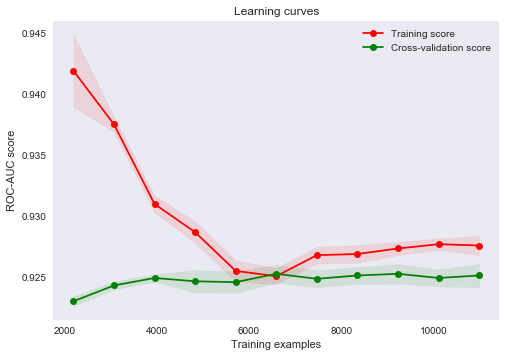

In [17]:
plot_learning_curve(estimator = xgb_w4, title = 'Learning curves',X = data_train_train1[SFS_features]
                    , y = y_train_train, cv = skf)
plt.show()

Что мы видим? Действительно, тестовая кривая примерно на 6700 тренировчных образцов сходится с тренировочной, а дальше - качество на тесте не растет. Так что, судя по графику, дальнейшее увеличение размера обучающей выборки перестает влиять на качество модели на тесте.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.
2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Сделано в начале предыдущего раздела (вариация параметра scale_pos_weight). Результаты классификации меняются в худшую сторону, ухудшая качество модели. Оптимальным является вариант - оставить этот параметр равным 1.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Тестировать влияние Undersamping нужно на выборке с реальным балансом классов, поэтому возьмем нашу наилушую тренировочную выборку data_train_train1[SFS_features], разобьем на train-test, временно добавим к train столбец меток, найдем индексы, соответствующие разным классам. 

In [18]:
df_t, df_v, y_t,y_v = train_test_split(data_train_train1[SFS_features], y_train_train, 
                                                      test_size=0.2, 
                                                     random_state=17, stratify=y_train_train, shuffle = True)
df_t ['target'] = y_t
churn_indices = df_t [df_t.target == 1].index
nchurn_indices = df_t [df_t.target == -1].index
print churn_indices.shape
print nchurn_indices.shape

(882L,)
(10828L,)


Выше на кривых мы увидели число 6700, посмотрим при каком соотношении классов (при использовании всех объектов класса 'отток') оно достигается.

In [20]:
(6700 - 882)/882.

6.596371882086168

Реальное соотношение классов:

In [22]:
(10828-882)/882.

11.276643990929704

Возьмем список ratios из 6 соотношений классов, куда включим и полученные два значения. Сделаем обучающие выборки с этими соотношениями классов. Каждому соотношению классов будет соответвовать 5 выборок - отбираем объекты класса 'не-отток' c 5 параметрами random.seed. Обучаем на этих выборках классификатор, смотрим качество на тестовой подвыборке, усредняем качество для каждого соотношения классов, смотрим, что получилось.

In [34]:
ratios = [ 1,2, 5, 6.6, 9, 11.277 ]
X_us  = np.zeros((6,5))
for l,rs in enumerate([0,3,17,42,555]):
    roc_aucs = []
    for class_ratio in ratios:
            np.random.seed(rs)
            nchurn_indices_us = np.random.choice(nchurn_indices, size = int(np.ceil(churn_indices.shape[0]* class_ratio)))
            df_t_us = pd.concat((df_t.loc[churn_indices], df_t.loc[nchurn_indices_us]), axis = 0)
            y_t_us = df_t_us.target
            df_t_us.drop('target', axis = 1, inplace = True)
        
            roc_aucs.append( validation( XGBClassifier(n_jobs = -1), df_t_us, df_v, y_t_us,y_v )   )
    X_us [:, l] = np.array(roc_aucs)
print pd.DataFrame( X_us.mean(axis = 1), index = ratios)

               0
1.000   0.706226
2.000   0.712857
5.000   0.715373
6.600   0.716500
9.000   0.720765
11.277  0.720874


Видим, что наилучшее качество все-таки при использовании всех объектов класса 'не-отток'. 
При соотношениях, отличных от реального, результаты классификации меняются в худшую сторону, ухудшая качество модели. Оптимальным является вариант -undesampling не применять.
Мало того, мною предпринимались попытки сделать 'умный' undersampling  в ноутбуке python 3 с помощью методов библиотеки imblearn ( ClusterCentroids,  TomekLinks) - тоже не помогло.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

В данной модели пропуски в вещественных признаках лучше не обрабатывать (сравнение проведено выше). Заполнение медианным значением, нулем или аномальной константой ухудшают качество. Незначительно ухудшает качество заполнение средним.
В категориальных признаках хэширование и LabelEncoder выделяли пропуски в отдельную категорию (выше).
Попробуем еще посмотреть качество на закодированных LabelEncoder'ом признаках, где пропуски заменены на наиболее часто встречающееся значение.

In [38]:
data_train_train_NaN_top = data_train_train_cat.copy(deep = True)
data_train_train_NaN_top.drop(['Var230','Var209'], axis = 1, inplace = True)
data_train_train_NaN_top_describe = data_train_train_NaN_top.describe()
for c in data_train_train_NaN_top.columns:
    data_train_train_NaN_top[c].fillna(data_train_train_NaN_top_describe[c]['top'], inplace = True) 

print 'roc_auc LE, NaN to Top', cross_val_score(XGBClassifier(n_jobs = -1)
                                                ,LE.fit_transform(data_train_train_NaN_top,axis =1)
                                                                  ,y_train_train,cv = skf,scoring = 'roc_auc').mean()

roc_auc LE, NaN to Top 0.6482398934418188


Нет, так хуже, чем выделять пропуски в отдельную категорию. Выделять пропуски в отдельную категорию - оптимальный вариант.

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Сделано выше. Попробуем ещё комбинированный вариант - категориальные признаки, где больше 10 значений, обработаем FeatureHasher, остальные - OneHotEncoder.

In [23]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False)
def ohe_to_DataFrame(data, data_columns, train_size):
    data_encoded = ohe.fit_transform(data.astype((str)))
    new_columns = []
    for clmn in data_columns:
        new_columns.extend(clmn+'='+str(i) for i in range( max ([data_train_train_cat[clmn].astype((str)).nunique() ,data_train_valid_cat[clmn].astype((str)).nunique()]) ) )
                
    return pd.DataFrame(data_encoded[:train_size], columns = new_columns), pd.DataFrame(data_encoded[train_size:], columns = new_columns)

In [17]:
# выделяем признаки, где много категорий
cat_columns_many_values = []
for c in data_train_cat.columns:
    if data_train_cat[c].nunique() > 10:
        cat_columns_many_values.append(c)
cat_columns_many_values

['Var192',
 'Var193',
 'Var195',
 'Var197',
 'Var198',
 'Var199',
 'Var200',
 'Var202',
 'Var204',
 'Var206',
 'Var207',
 'Var212',
 'Var214',
 'Var216',
 'Var217',
 'Var219',
 'Var220',
 'Var222',
 'Var226',
 'Var228']

In [18]:
data_train_train_cat_hashed_combo, data_train_valid_cat_hashed_combo = FeatureHashing(data_train_train_cat [cat_columns_many_values]
                                                                                      , data_train_valid_cat [cat_columns_many_values])

In [26]:
ohe_columns =  list(set(data_train_train_cat.columns).difference(cat_columns_many_values + ['Var209','Var230']))
data_train_train_cat_ohe_combo, data_train_valid_cat_ohe_combo = ohe_to_DataFrame(np.vstack(( data_train_train_cat[ohe_columns].values
                                                                                             , data_train_valid_cat[ohe_columns].values))
                                                     , data_train_train_cat[ohe_columns].columns, data_train_train_cat.shape[0])
                                                                                 
                                                                                

In [27]:
data_train_train_cat_combo = pd.concat((data_train_train_cat_hashed_combo,data_train_train_cat_ohe_combo), axis = 1) 
print 'roc_auc cat combo', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train_cat_combo,y_train_train,cv = skf,scoring = 'roc_auc').mean()

roc_auc cat combo 0.655329232328683


Вроде бы лучше, чем просто хэширование! А теперь соединим ЭТО с вещественными признаками и посмотрим качество на кросс -валидации и на валидационной выборке классификатором с параметрами по умолчанию.

In [81]:
data_train_train_combo = pd.concat((data_train_train_num1, data_train_train_cat_combo.set_index(data_train_train_num1.index)) , axis = 1)
print 'roc_auc combo', cross_val_score(XGBClassifier(n_jobs = -1),data_train_train_combo,y_train_train,cv = skf,scoring = 'roc_auc').mean()
data_train_valid_cat_combo = pd.concat((data_train_valid_cat_hashed_combo
                                        ,data_train_valid_cat_ohe_combo.set_index(data_train_valid_cat_hashed_combo.index)), axis = 1) 
data_train_valid_combo = pd.concat((data_train_valid_num1, data_train_valid_cat_combo.set_index(data_train_valid_num1.index)), axis = 1)
print 'validation', validation(XGBClassifier(n_jobs = -1),data_train_train_combo, data_train_valid_combo, y_train_train, y_train_valid)

roc_auc combo 0.7321326241329421
validation 0.7294072780985632


Хм... на кросс-валидации мы получаем качество хуже, чем при хэшировании всех категориальных признаков, на валидации - лучше. Сверимся с kaggle.

In [29]:
def ohe_to_DataFrame_test(data, data_columns, train_size):
    data_encoded = ohe.fit_transform(data.astype((str)))
    new_columns = []
    for clmn in data_columns:
        new_columns.extend(clmn+'='+str(i) for i in range( max ([data_train_cat[clmn].astype((str)).nunique() ,data_test_cat[clmn].astype((str)).nunique()]) ) )
                
    return pd.DataFrame(data_encoded[:train_size], columns = new_columns), pd.DataFrame(data_encoded[train_size:], columns = new_columns)

In [32]:
xgb_def_test4 = XGBClassifier(n_jobs = -1)

data_train_cat_hashed_combo, data_test_cat_hashed_combo = FeatureHashing(data_train_cat[cat_columns_many_values]
                                                             ,data_test_cat[cat_columns_many_values])

ohe_columns =  list(set(data_train_cat.columns).difference(cat_columns_many_values + ['Var209','Var230']))
data_train_cat_ohe_combo, data_test_cat_ohe_combo = ohe_to_DataFrame_test(np.vstack(( data_train_cat[ohe_columns].values
                                                                                , data_test_cat[ohe_columns].values))
                                                     , data_train_cat[ohe_columns].columns, data_train_cat.shape[0] )


data_train_cat_combo = pd.concat((data_train_cat_hashed_combo,data_train_cat_ohe_combo), axis = 1) 
data_test_cat_combo = pd.concat((data_test_cat_hashed_combo
                                        ,data_test_cat_ohe_combo.set_index(data_test_cat_hashed_combo.index)), axis = 1) 


data_train4 = pd.concat((data_train_num, data_train_cat_combo.set_index(data_train_num.index)), axis = 1)
data_test4 = pd.concat((data_test_num, data_test_cat_combo.set_index(data_test_num.index)), axis = 1)

xgb_def_test4.fit(data_train4, target)
test4_predictions =  xgb_def_test4.predict_proba(data_test4) [:,1]

write_to_submission_file(test4_predictions,'submission04.csv') #kaggle - 0.71523

Нет, этот результат хуже, чем для модели, где категориальные признаки были хешированы полностью (оптимальный вариант).

Также мною было опробованы методы Mean Target Encoding и вероятностное кодирование (вместо категории подставляется вероятность её получить), не давшие улучшения качества. Так как у меня нет 100% уверенности, что это было сделано корректно, здесь их не привожу.


5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

Нет, не все признаки оказались полезными для построения моделей.  Сначала модель XGBoostclassifier отобрала 136 признаков из 418 (список f_imp_list_xgb, выше), потом мы использовали SequentialFeatureSelector, отобравший из них 51 признак.

RFE из модуля sklearn.feature_selection отказывается обрабатывать NaN, которые есть в вещественных признаках. 

Поэтому просто попробуем отобрать  1/3, 1/2, 2/3 и 5/6 доли из 136 признаков, отобранных моделью: берем нужное количество самых важных признаков из списка f_imp_list_xgb, смотрим качество на кросс-валидации классификатором с параметрами по умолчанию. 


In [61]:
from sklearn.feature_selection import RFE
for pf in [1/3.,1/2.,2/3.,5/6.]:
    nf = int(np.ceil(pf*len(mean_f_imp_list_xgb.keys())))
    print 'roc_auc, portion: {:.2f} features '.format (pf) ,cross_val_score(XGBClassifier(n_jobs = -1)
                                                                        ,data_train_train1[f_imp_list_xgb.keys()[- nf :]]
                                                                        ,y_train_train,cv = skf,scoring = 'roc_auc').mean()

roc_auc, portion: 0.33 features  0.7399399274311105
roc_auc, portion: 0.50 features  0.7421349436198246
roc_auc, portion: 0.67 features  0.7364718604289893
roc_auc, portion: 0.83 features  0.7370197202132331


Как и следовало ожидать, качество такого отбора не превысило качество отбора SFS, но такой отбор все же лучше, чем никакого(напомню, что качество без отбора - 0.7332). Оставляем в модели признаки, отобранные SFS (качество тем же классификатором - 0.75445).

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

В предыдущих экспериментах нам не удалось улучшить качество модели, поэтому проводить повторный подбор тех же параметров ни к чему. Но мы попробуем поварьировать параметр gamma, который отвечает за порог уменьшения ошибки, необходимый для разбиения вершины деревьев.

In [62]:
gamma_params= {
 'gamma':[i/10.0 for i in range(0,5)]
}
gamma_grid_searcher = GridSearchCV(XGBClassifier( n_estimators=150, n_jobs=-1), gamma_params, scoring = 'roc_auc', cv = skf)
gamma_grid_searcher.fit(data_train_train1[SFS_features], y_train_train)
print gamma_grid_searcher.best_score_, gamma_grid_searcher.best_params_

0.7556942665257403 {'gamma': 0.4}


Видим улучшение в 4-м знаке. Ещё попробуем варьировать параметр L2-регуляризации lambda.

In [68]:
lambda_params= {
 'lambda':  [1000, 1000000] #[1, 1e-5, 1e-2, 0.1, 100]
}
lambda_grid_searcher = GridSearchCV(XGBClassifier( n_estimators=150, gamma = 0.4, n_jobs=-1), lambda_params, scoring = 'roc_auc', cv = skf)
lambda_grid_searcher.fit(data_train_train1[SFS_features], y_train_train)
print lambda_grid_searcher.best_score_, lambda_grid_searcher.best_params_

0.7556942665257403 {'lambda': 1000}


Получилось, что от данного параметра уже ничего не зависит.

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

Реализуем уже использованный при отборе признаков "feature_importances" для модели XGBoostClassifier на отобранных признаках.

In [16]:
xgb_final = XGBClassifier( n_estimators=150, gamma = 0.4, n_jobs=-1)
xgb_final.fit(data_train_train1[SFS_features],y_train_train)
from collections import OrderedDict
f = 'gain'

d_final = xgb_final.get_booster().get_score(importance_type= f)
f_imp_list_xgb_final = OrderedDict (sorted(d_final.items(), key=lambda t: t[1]))
print len(list(f_imp_list_xgb_final))
f_imp_list_xgb_final

47


OrderedDict([('Var217_4', 2.9669509581818185),
             ('Var206_5', 3.177804521428572),
             ('Var208_2', 3.492371056666667),
             ('Var216_4', 3.640114989666666),
             ('Var216_1', 3.688477551285714),
             ('Var111', 3.7428087893750006),
             ('Var219_2', 3.8058641275),
             ('Var9', 3.840281862857143),
             ('Var220_2', 4.060627796),
             ('Var202_5', 4.135176083636363),
             ('Var216_5', 4.32768820375),
             ('Var211_3', 4.41582918),
             ('Var57', 4.488888978171873),
             ('Var199_1', 4.656870895384615),
             ('Var222_0', 4.693028036666666),
             ('Var78', 4.7225441925),
             ('Var200_0', 4.909671915555555),
             ('Var227_5', 5.006691136666667),
             ('Var202_3', 5.012215862083334),
             ('Var220_1', 5.013375045),
             ('Var228_1', 5.147980133333333),
             ('Var226_3', 5.15403239),
             ('Var197_2', 5.3569070973

In [194]:
set(SFS_features).difference(set(f_imp_list_xgb_final.keys()))

{'Var30', 'Var45', 'Var5', 'Var50'}

Итак, для модели являются важными 47 признаков (список f_imp_list_xgb_final), важность возрастает к концу. Меньший вклад внесли признаки в начале списка, а признаки 30, 45, 5 и 50 из списка SFS финальная модель тоже не сочла важными.

Этот список несколько отличается от первоначального списка (f_imp_list_xgb), но top-3 признака остаются теми же: 226_1, 218_2, 126. Как эти признаки соотносятся с нашими предположениями из первичного анализа данных? Важности вещественных признаков, в основном, согласуются - 73, 126, 189 - в топе, 7 - не попал. Среди наиболее коррелирующих категориальных признаков в топ-10 остался 199 и часть 216, 218 был номером 11 - отсюда вывод: зависимости категориальных признаков отличаются от линейных и огромное количество категорий не идёт на пользу модели.


Дополнительно попробуем добавить полиномиальные признаки (3-я степень), полученные из наиболее важных вещественных признаков 73 и 126.

In [102]:
data_for_poly = data_train_train1[SFS_features].copy(deep = True)
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree= 3)

In [103]:
mean_imputer=SimpleImputer(missing_values=np.nan, strategy='mean')
poly_features= pd.DataFrame(mean_imputer.fit_transform(data_for_poly[['Var73', 'Var126']])
                                                      ,columns = ['Var73', 'Var126'])
poly_features = poly_transformer.fit_transform(poly_features)
poly_features = pd.DataFrame(poly_features, 
                             columns =poly_transformer.get_feature_names(input_features = [ 'Var73', 'Var126']))

In [104]:
poly_features['TARGET'] = y_train_train
poly_corrs = abs(poly_features.corr()['TARGET']).sort_values()
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

Var126^2          0.000535
Var126            0.005789
Var73^3           0.006681
Var73 Var126      0.006830
Var73 Var126^2    0.007218
Var73^2 Var126    0.007525
Var126^3          0.007724
Var73^2           0.010073
Var73             0.014379
TARGET            1.000000
Name: TARGET, dtype: float64
Var126^3    0.007724
Var73^2     0.010073
Var73       0.014379
TARGET      1.000000
1                NaN
Name: TARGET, dtype: float64


Да, признаки 126^3, и 73^2 имеют корреляцию с целевой переменной выше, чем признак 126, но незначительно, так что их добавление вряд ли увеличит качеcnво модели, что мы и видим на кросс-валидации:

In [109]:
data_for_poly = np.hstack((data_for_poly.values, poly_features[['Var126^3','Var73^2']].values))
cross_val_score(xgb_final,data_for_poly ,y_train_train,cv = skf,scoring = 'roc_auc').mean()

0.7556937835415517

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

С помощью cross_val_predict посчитаем вероятности отнесения объектов к классам и запишем их в датафрейм, к которому добавим столбец верных меток.

In [23]:
scores = cross_val_predict( xgb_final,data_train_train1[SFS_features] ,y_train_train ,cv = skf,method= 'predict_proba')
scores_df = pd.DataFrame(zip(scores[:, 0], scores[:,1], y_train_train.values), columns = ['predict_proba_-1','predict_proba_1', 'y'], index = y_train_train.index)

Итак, для сравнения посмотрим на 4 типа объектов: 

- объекты, которые классификатор с вероятностью > 0.987 относит к классу 'не - отток', когда эти объекты в классе 'отток';

- объекты, которые классификатор наиболее уверенно (>0.9975) правильно относит к rлассу 'не отток';

- объекты, которые классификатор с вероятностью > 0.5 относит к классу 'отток', когда эти объекты в классе 'не- отток'.   

- объекты, которые классификатор наиболее уверенно (>0.5) правильно относит к rлассу 'отток'.

(Пороги вероятности подбираем, чтобы объектов было достаточно для анализа, но в обозримом количестве. По этим "самым типичным" объектам и будем делать выводы. Для рассмотрения берём 10 самых важные признаков, важность возрастает слева направо.)

In [56]:
# объекты, ошибочно уверенно отнесенные к '-1'
print scores_df[(scores_df['predict_proba_-1'] > 0.987) & (scores_df.y == 1)]
data_train_train1[SFS_features].ix[scores_df[(scores_df['predict_proba_-1'] > 0.987) & (scores_df.y == 1)].index, -10: ]

       predict_proba_-1  predict_proba_1    y
ID                                           
15142          0.988008         0.011992  1.0
8034           0.987490         0.012510  1.0
3224           0.989519         0.010481  1.0
3276           0.987270         0.012730  1.0
5466           0.989579         0.010421  1.0
9457           0.990814         0.009186  1.0
12639          0.993346         0.006654  1.0
7416           0.989392         0.010608  1.0
1217           0.992322         0.007678  1.0
4309           0.989389         0.010611  1.0
784            0.990243         0.009757  1.0
8067           0.987527         0.012473  1.0
12228          0.989174         0.010826  1.0
12340          0.988101         0.011899  1.0
12071          0.987608         0.012392  1.0
11735          0.987298         0.012702  1.0


,Var198_0,Var74,Var219_4,Var218_1,Var189,Var205_2,Var73,Var126,Var218_2,Var226_1
ID,,,,,,,,,,
15142,0.0,56.0,0.0,1.0,276.0,0.0,50,-30.0,-1.0,1.0
8034,-1.0,0.0,0.0,1.0,NaN,0.0,18,-30.0,-1.0,0.0
3224,-1.0,63.0,0.0,1.0,NaN,0.0,160,-26.0,-1.0,0.0
3276,0.0,56.0,0.0,1.0,NaN,0.0,54,8.0,-1.0,-1.0
5466,-1.0,294.0,1.0,0.0,360.0,0.0,244,16.0,-1.0,0.0
9457,-1.0,329.0,0.0,1.0,NaN,0.0,220,NaN,-1.0,0.0
12639,0.0,42.0,0.0,0.0,402.0,0.0,118,NaN,-1.0,0.0
7416,-2.0,266.0,0.0,1.0,174.0,0.0,108,-30.0,-1.0,2.0
1217,-1.0,70.0,0.0,1.0,216.0,0.0,80,-28.0,-1.0,-1.0


In [58]:
# объекты, верно уверенно отнесенные к '-1'
print scores_df[(scores_df['predict_proba_-1'] > 0.9975) & (scores_df.y == -1)]
data_train_train1[SFS_features].ix[scores_df[(scores_df['predict_proba_-1'] > 0.9975) & (scores_df.y == -1)].index, -10:]

       predict_proba_-1  predict_proba_1    y
ID                                           
12158          0.998128         0.001872 -1.0
7428           0.997506         0.002494 -1.0
7133           0.998080         0.001920 -1.0
13201          0.998297         0.001703 -1.0
15563          0.998077         0.001923 -1.0
13006          0.997531         0.002469 -1.0
4893           0.998081         0.001919 -1.0
5697           0.998695         0.001305 -1.0
12631          0.998234         0.001766 -1.0
4183           0.997547         0.002453 -1.0
8541           0.997875         0.002125 -1.0


,Var198_0,Var74,Var219_4,Var218_1,Var189,Var205_2,Var73,Var126,Var218_2,Var226_1
ID,,,,,,,,,,
12158,-1.0,0.0,0.0,0.0,396.0,0.0,198,-30.0,-1.0,0.0
7428,0.0,3675.0,0.0,0.0,NaN,0.0,108,-30.0,-1.0,0.0
7133,0.0,28.0,0.0,1.0,NaN,0.0,60,-30.0,-1.0,0.0
13201,-1.0,392.0,0.0,1.0,342.0,0.0,122,-30.0,-1.0,1.0
15563,-1.0,833.0,0.0,0.0,306.0,0.0,78,-30.0,-1.0,1.0
13006,0.0,245.0,0.0,0.0,450.0,0.0,156,-26.0,-1.0,0.0
4893,1.0,0.0,0.0,1.0,NaN,0.0,32,-30.0,-1.0,0.0
5697,1.0,1925.0,0.0,1.0,342.0,0.0,130,-30.0,-1.0,0.0
12631,0.0,70.0,0.0,0.0,642.0,0.0,74,-28.0,-1.0,0.0


In [64]:
# объекты, ошибочно уверенно отнесенные к '1'
print scores_df[(scores_df['predict_proba_1'] > 0.5) & (scores_df.y == -1)]
data_train_train1[SFS_features].ix[scores_df[(scores_df['predict_proba_1'] > 0.5) & (scores_df.y == -1)].index, -10: ]

       predict_proba_-1  predict_proba_1    y
ID                                           
9738           0.409256         0.590744 -1.0
7678           0.457782         0.542218 -1.0
15059          0.409278         0.590722 -1.0
17147          0.438651         0.561349 -1.0
10087          0.464921         0.535079 -1.0
6248           0.407426         0.592574 -1.0
316            0.446057         0.553943 -1.0
7029           0.485915         0.514085 -1.0
12899          0.396602         0.603398 -1.0
11929          0.398210         0.601790 -1.0
18232          0.450585         0.549415 -1.0
852            0.493008         0.506992 -1.0
277            0.230293         0.769707 -1.0


,Var198_0,Var74,Var219_4,Var218_1,Var189,Var205_2,Var73,Var126,Var218_2,Var226_1
ID,,,,,,,,,,
9738,1.0,0.0,0.0,0.0,138.0,0.0,12,4.0,0.0,0.0
7678,0.0,0.0,1.0,1.0,NaN,0.0,16,-8.0,-1.0,1.0
15059,2.0,0.0,0.0,0.0,NaN,0.0,20,NaN,0.0,0.0
17147,-1.0,0.0,0.0,0.0,NaN,0.0,14,NaN,0.0,0.0
10087,0.0,0.0,0.0,0.0,NaN,3.0,28,4.0,-1.0,0.0
6248,1.0,0.0,0.0,0.0,NaN,0.0,12,NaN,0.0,0.0
316,-1.0,224.0,0.0,0.0,NaN,0.0,200,-8.0,0.0,1.0
7029,-1.0,0.0,1.0,0.0,150.0,3.0,16,NaN,0.0,0.0
12899,0.0,0.0,0.0,0.0,NaN,0.0,14,-10.0,0.0,1.0


In [66]:
# объекты, верно уверенно отнесенные к '1'
print scores_df[(scores_df['predict_proba_1'] > 0.5) & (scores_df.y == 1)]
data_train_train1[SFS_features].ix[scores_df[(scores_df['predict_proba_1'] > 0.5) & (scores_df.y == 1)].index, -10: ]

       predict_proba_-1  predict_proba_1    y
ID                                           
1363           0.388586         0.611414  1.0
13420          0.388386         0.611614  1.0
5812           0.449070         0.550930  1.0
12708          0.268009         0.731991  1.0
15040          0.492851         0.507149  1.0
437            0.392937         0.607063  1.0
7222           0.494054         0.505946  1.0
1898           0.457897         0.542103  1.0
14055          0.362765         0.637235  1.0
10943          0.349597         0.650403  1.0
5282           0.394923         0.605077  1.0
5584           0.465515         0.534485  1.0
8388           0.416008         0.583992  1.0
8441           0.492314         0.507686  1.0
16288          0.383072         0.616928  1.0
18067          0.383942         0.616058  1.0
10670          0.499420         0.500580  1.0


,Var198_0,Var74,Var219_4,Var218_1,Var189,Var205_2,Var73,Var126,Var218_2,Var226_1
ID,,,,,,,,,,
1363,0.0,0.0,0.0,0.0,NaN,0.0,16,-8.0,0.0,0.0
13420,0.0,0.0,0.0,0.0,138.0,3.0,12,-14.0,0.0,0.0
5812,1.0,28.0,0.0,0.0,NaN,0.0,54,NaN,0.0,0.0
12708,0.0,0.0,0.0,0.0,NaN,3.0,16,-8.0,0.0,-1.0
15040,2.0,0.0,0.0,0.0,216.0,3.0,76,NaN,0.0,0.0
437,1.0,7.0,0.0,0.0,216.0,0.0,46,NaN,0.0,0.0
7222,0.0,0.0,0.0,0.0,192.0,0.0,18,NaN,0.0,0.0
1898,0.0,NaN,1.0,0.0,NaN,0.0,8,-8.0,-1.0,0.0
14055,0.0,0.0,0.0,0.0,168.0,3.0,28,4.0,0.0,0.0


Итак, признаки.
- 226_1: Трудно что-то сказать по небольшому числу объектов, в обоих классах много нулевых значений, есть значения 1.0; -1.0, 2.0.
- 218_2: Для класса -1 характерно значение -1.0. Для класса 1 - скорее, значение 0.0, но -1.0 тоже есть. Поэтому классификатор ошибается.
- 126: Для класса -1 характерные значения -26.0, -28.0, -30.0. Для класса 1: -8.0,-10.0,-12.0,4.0, пропуски. Различия распределения по классам этого признака хорошо видны на гистограммах в начале ноутбука. Когда встречаются значения, характерные для класса, отличного, от класса объекта, модель склонна ошибаться.
- 73: Для класса -1, в основном, характерны значения > 30, есть значения >100. Для класса 1 - 8, 12, 14, 16, есть и больше, но меньше 100.
- 189: Для класса -1, в основном, характерны значения > 300, пропуски. Для класса 1 - от 126 до 216, пропуски. Вообще, здесь больше половины значений пропущено. Гистограммы в разрезе классов для этого признака (и для предыдущего) не очень сильно отличаются друг от друга.
- По менее важным признакам уже труднее проводить анализ. Например, для признака 74 в  классе 1 характерны нулевые и относительно небольшие значения, в классе -1 разброс значений от нуля до очень больших, везде есть пропуски. Как я понимаю, модель может ошибаться,  когда относит объекты с нулевыми и относительно малыми значениями этого признака к оттоку, с большими - к не-оттоку.

Попробуем выбросить объекты с наибольшей ошибкой классификации.

In [119]:
#определяем число объектов каждого класса
print y_train_train[y_train_train == 1].shape[0]
print y_train_train[y_train_train == -1].shape[0]

1102
13536


In [117]:
# подбираем порог вероятности, чтобы у нас было какое-то приемлемое количество объектов
# пусть будет 29 - 2.6 % 
scores_df[(scores_df['predict_proba_1'] > 0.45) & (scores_df.y == -1)].count()

predict_proba_-1    29
predict_proba_1     29
y                   29
dtype: int64

In [193]:
29./1102

0.02631578947368421

In [126]:
# посмотрим, сколько объектов класса 'не-отток' нужно взять, чтобы выбросить тот же процент
29/1102.*13536

356.2105263157895

In [130]:
#подбираем порог вероятности
scores_df[(scores_df['predict_proba_-1'] > 0.92) & (scores_df.y == 1)].count()

predict_proba_-1    354
predict_proba_1     354
y                   354
dtype: int64

In [142]:
# фильтруем данные
most_error_churn_indices = scores_df[(scores_df['predict_proba_1'] > 0.45) & (scores_df.y == -1)].index
most_error_nchurn_indices =scores_df[(scores_df['predict_proba_-1'] > 0.92) & (scores_df.y == 1)].index
trash_indices = set(most_error_churn_indices) | set(most_error_nchurn_indices)
data_train_train_filtered = data_train_train1[SFS_features].drop(trash_indices, axis = 0)
y_train_train_filtered = y_train_train.drop(trash_indices, axis = 0)

In [143]:
# понятно, что здесь качество выросло
cross_val_score(xgb_final,data_train_train_filtered ,y_train_train_filtered,cv = skf,scoring = 'roc_auc').mean()

0.879666691411571

Проверим финальную модель (с подобранным значением gamma), обученную на данных, отфильтрованных от объектов с наибольшей ошибкой классификации на отложенной выборке.

In [144]:
# здесь качество стало чуть лучше
validation(xgb_final,data_train_train_filtered , data_train_valid1[SFS_features], y_train_train_filtered, y_train_valid)

0.7297483550422988

Идем проверять на kaggle. Делаем аналогичные шаги.

In [184]:
scores_all_train = cross_val_predict( xgb_final,data_train1[SFS_features] ,target ,cv = skf,method= 'predict_proba')
scores_df_all_train = pd.DataFrame(zip(scores_all_train[:, 0], scores_all_train[:,1], target.values), columns = ['predict_proba_-1','predict_proba_1', 'y'], index = target.index)

In [185]:
print target[target == 1].shape[0]
print target[target == -1].shape[0]

1377
16921


In [186]:
scores_df_all_train[(scores_df_all_train['predict_proba_1'] > 0.45) & (scores_df_all_train.y == -1)].count()

predict_proba_-1    29
predict_proba_1     29
y                   29
dtype: int64

In [187]:
print 29/1377.
print 29/1377. * 16921

0.0210602759622
356.360929557


In [189]:
scores_df_all_train[(scores_df_all_train['predict_proba_-1'] > 0.935) & (scores_df_all_train.y == 1)].count()

predict_proba_-1    354
predict_proba_1     354
y                   354
dtype: int64

In [190]:
most_error_churn_indices_all_train = scores_df_all_train[(scores_df_all_train['predict_proba_1'] > 0.45) & (scores_df_all_train.y == -1)].index
most_error_nchurn_indices_all_train =scores_df_all_train[(scores_df_all_train['predict_proba_-1'] > 0.935) & (scores_df_all_train.y == 1)].index
trash_indices_all_train = set(most_error_churn_indices_all_train) | set(most_error_nchurn_indices_all_train)
data_train_filtered = data_train1[SFS_features].drop(trash_indices_all_train, axis = 0)
target_filtered = target.drop(trash_indices_all_train, axis = 0)

In [191]:
xgb_final.fit(data_train_filtered, target_filtered)
test5_predictions =  xgb_final.predict_proba(data_test1[SFS_features]) [:,1]

write_to_submission_file(test5_predictions,'submission05.csv') #kaggle - 0.709

Фокус не удался, качество упало.

Теперь посмотрим, так ли уж полезно было подбирать параметр gamma?

In [192]:
xgb_final.fit(data_train1[SFS_features], target)
test6_predictions =  xgb_final.predict_proba(data_test1[SFS_features]) [:,1]

write_to_submission_file(test6_predictions,'submission06.csv') #kaggle - 0.72076

Совсем чут-чуть, но качество стало хуже, чем полученное на 4-й неделе. Итог -эксперименты с моделью нам не помогли улучшить ее качество.

9. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Описание финального решения:

В качестве классификатора использован XGBClassifier, число деревьев - 150:    XGBClassifier( n_estimators=150, n_jobs=-1).
Параметр n_jobs = -1 задан для распараллеливания.

В вещественных признаках пропуски оставлены, в категориальных - заменены на 'NA', значения категориальных признаков переведены строки. Далее категориальные признаки были закодированы с помощью FeatureHasher, каждый признак кодировали с помощью 6 новых признаков.

Затем был проведен отбор признаков, сначала - с помощью модели XGBClassifier с параметрами по умолчанию (получили 136 признаков), потом с помощью SequentialFeatureSelector из библиотеки mlxtend. Полученный набор из 51 признаков использовали для обучения модели и для предсказания классов на тестовой выборке.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

1. Собрать больше данных. Кстати, здесь приходит в голову читерское решение - обучить классификатор на бОльшей выборке из 1-3 недель, это ещё можно назвать элегантным оборотом из статей про участие на Kaggle - "использование внешних данных".
2. Детально поработать с обработкой пропусков, например, попробовать EM-алгоритм.
3. Профессионально скорректировать модель после нахождения объектов с наибольшей ошибкой классификации.
4. Попробовать блендинг/cтекинг. В качестве базовых алгоритмов было бы любопытно взять бустинговые модели, у которых относительно хорошоя точность, но проблемы с полнотой, и линейные модели, у которых обратная ситуация.


In [7]:
# Обучаем на бОльшей выборке из предыдущих недель
data40 = pd.read_csv('orange_small_churn_data.train')
target40 = pd.read_csv('orange_small_churn_labels.train', header = None)


In [10]:
data40_train_train, data40_train_valid, y40_train_train, y40_train_valid = train_test_split(data40
                                                      , target40, 
                                                      test_size=0.2, 
                                                     random_state=17, stratify=target40, shuffle = True)
data40_train_train_num = data40_train_train.iloc[:,:190]
data40_train_train_cat = data40_train_train.iloc[:,190:]

data40_train_valid_num = data40_train_valid.iloc[:,:190]
data40_train_valid_cat = data40_train_valid.iloc[:,190:]

In [11]:
data40_train_train_cat_hashed, data40_train_valid_cat_hashed = FeatureHashing(data40_train_train_cat.drop(['Var230','Var209'],axis =1) 
                                                                    , data40_train_valid_cat.drop(['Var230','Var209'],axis =1) )


In [12]:
data40_train_train = pd.concat((data40_train_train_num, data40_train_train_cat_hashed.set_index(data40_train_train_num.index)) , axis = 1)                                     
data40_train_valid = pd.concat((data40_train_valid_num, data40_train_valid_cat_hashed.set_index(data40_train_valid_num.index)), axis = 1)

In [17]:
import warnings
warnings.filterwarnings('ignore')
print 'roc_auc', cross_val_score(XGBClassifier(n_jobs = -1),data40_train_train  ,y40_train_train,cv = skf,scoring = 'roc_auc').mean()

roc_auc 0.7402158898753063


In [18]:
import warnings
warnings.filterwarnings('ignore')
print 'roc_auc', cross_val_score(XGBClassifier( n_estimators=150, n_jobs=-1),data40_train_train [SFS_features]  ,y40_train_train,cv = skf,scoring = 'roc_auc').mean()

roc_auc 0.7402592984638767


In [19]:
validation(XGBClassifier( n_estimators=150, n_jobs=-1),data40_train_train[SFS_features], data40_train_valid[SFS_features], y40_train_train, y40_train_valid)

0.7387406873620481

In [27]:
xgb_test40 = XGBClassifier( n_estimators=150, n_jobs=-1)

data40_train_num = data40.iloc[:,:190]
data40_train_cat = data40.iloc[:,190:]


data40_train_cat_hashed, data_test_cat_hashed = FeatureHashing(data40_train_cat.drop(['Var230','Var209'],axis =1) 
                                                             ,data_test_cat.drop(['Var230','Var209'],axis =1))

data40_train = pd.concat((data40_train_num, data40_train_cat_hashed.set_index(data40_train_num.index)), axis = 1)
data40_test = pd.concat((data_test_num, data_test_cat_hashed.set_index(data_test_num.index)), axis = 1)

xgb_test40.fit(data40_train[SFS_features], target40)
test40_predictions =  xgb_test40.predict_proba(data40_test[SFS_features]) [:,1]

write_to_submission_file(test40_predictions,'submission40.csv') # да, на kaggle выборка лучше даже предыдцщми параметрами и признаками 

In [28]:
xgb_def = XGBClassifier(n_jobs = -1)
xgb_def.fit(data40_train_train,y40_train_train)
from collections import OrderedDict
f = 'gain'

d = xgb_def.get_booster().get_score(importance_type= f)
f_imp_list_xgb40 = OrderedDict (sorted(d.items(), key=lambda t: t[1]))
print len(list(f_imp_list_xgb40))
f_imp_list_xgb40

129


OrderedDict([('Var205_5', 0.516851187),
             ('Var96', 1.4511919),
             ('Var229_1', 2.87169456),
             ('Var198_4', 3.06650734),
             ('Var108', 3.29487228),
             ('Var45', 3.381981744444444),
             ('Var139', 3.4123497),
             ('Var136', 3.53697681),
             ('Var192_2', 3.809487345),
             ('Var197_5', 3.92137337),
             ('Var3', 4.082967123333333),
             ('Var102', 4.60498142),
             ('Var106', 4.65495205),
             ('Var217_1', 4.748191835),
             ('Var80', 4.87659836),
             ('Var202_3', 5.013328315),
             ('Var202_2', 5.16403389),
             ('Var205_0', 5.27776623),
             ('Var117', 5.35062838),
             ('Var76', 5.387803314999999),
             ('Var157', 5.46278381),
             ('Var198_3', 5.61662865),
             ('Var53', 5.6397798539999995),
             ('Var188', 5.726405145),
             ('Var192_5', 5.737455053333334),
             ('Var168

In [29]:
feature_selector40 = SFS(XGBClassifier(n_jobs = -1), scoring='roc_auc'
                                        , verbose=2, k_features=75, forward=True, n_jobs=-1, cv = skf)
feature_names = data40_train_train[f_imp_list_xgb40.keys()].columns
feature_selector40.fit(data40_train_train[f_imp_list_xgb40] ,y40_train_train, custom_feature_names=feature_names)
feature_selector40.subsets_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:  1.5min finished

[2019-10-08 15:59:05] Features: 1/75 -- score: 0.6641966615176409[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:  1.4min finished

[2019-10-08 16:00:28] Features: 2/75 -- score: 0.701886195906581[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 127 out of 127 | elapsed:  1.6min finished

[2019-10-08 16:02:03] Features: 3/75 -- score: 0.7139601612720623[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 126 out of

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  4.3min finished

[2019-10-08 17:42:21] Features: 31/75 -- score: 0.7479641841768228[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  4.4min finished

[2019-10-08 17:46:46] Features: 32/75 -- score: 0.7476676305775476[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  97 out of  97 | elapsed:  4.5min finished

[2019-10-08 17:51:17] Features: 33/75 -- score: 0.7482847665744796[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  4.5min finished

[2019-10-08 17:55:46] Features: 34/75 

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:  5.9min finished

[2019-10-08 20:18:07] Features: 61/75 -- score: 0.7489503260026905[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:  6.4min finished

[2019-10-08 20:24:31] Features: 62/75 -- score: 0.748562473938336[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  5.8min finished

[2019-10-08 20:30:20] Features: 63/75 -- score: 0.7488470965926094[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:  5.8min finished

[2019-10-08 20:36:06] Features: 64/75 -

{1: {'avg_score': 0.6641966615176409,
  'cv_scores': array([0.66044619, 0.64481607, 0.66052111, 0.69100327]),
  'feature_idx': (124,),
  'feature_names': ('Var126',)},
 2: {'avg_score': 0.701886195906581,
  'cv_scores': array([0.69180707, 0.68790041, 0.71109879, 0.71673851]),
  'feature_idx': (118, 124),
  'feature_names': ('Var73', 'Var126')},
 3: {'avg_score': 0.7139601612720623,
  'cv_scores': array([0.70424255, 0.70136077, 0.71930901, 0.73092832]),
  'feature_idx': (115, 118, 124),
  'feature_names': ('Var189', 'Var73', 'Var126')},
 4: {'avg_score': 0.7228539682853645,
  'cv_scores': array([0.71414959, 0.71068912, 0.72820851, 0.73836865]),
  'feature_idx': (115, 118, 119, 124),
  'feature_names': ('Var189', 'Var73', 'Var218_2', 'Var126')},
 5: {'avg_score': 0.7276128960740809,
  'cv_scores': array([0.72040092, 0.71522069, 0.73031247, 0.7445175 ]),
  'feature_idx': (113, 115, 118, 119, 124),
  'feature_names': ('Var113', 'Var189', 'Var73', 'Var218_2', 'Var126')},
 6: {'avg_score': 0

In [30]:
SFS_features40 =['Var96','Var229_1','Var198_4','Var108','Var139','Var136','Var3','Var106','Var217_1','Var202_3','Var205_0'
                 ,'Var157','Var192_5','Var222_3','Var228_4','Var193_5','Var196_0','Var207_5','Var197_2','Var22'
                 ,'Var214_5','Var228_1','Var216_0','Var216_2','Var221_1','Var220_3','Var199_0','Var212_0','Var84','Var197_0'
                 ,'Var222_5','Var197_4','Var220_1','Var226_2','Var226_3','Var216_5','Var210_0','Var16','Var21','Var149'
                 ,'Var88','Var220_0','Var61','Var208_2','Var181','Var210_1','Var229_2','Var6','Var103','Var203_1','Var205_3'
                 ,'Var113','Var189','Var73','Var218_2','Var74','Var218_1','Var126','Var205_2','Var225_4']

In [36]:
len(SFS_features40)

60

In [31]:
print 'roc_auc', cross_val_score(XGBClassifier( n_jobs=-1),data40_train_train [SFS_features40]  ,y40_train_train,cv = skf,scoring = 'roc_auc').mean()

roc_auc 0.7490922989829063


In [34]:
%%time
xgb_def = XGBClassifier( n_jobs=-1)
n_params = { 'n_estimators': [75, 150, 200, 500, 1000]}
             # ,   'learning_rate': [ 0.15 ,0.1]}
n_grid_searcher = GridSearchCV(xgb_def, n_params, scoring = 'roc_auc', cv = skf)
n_grid_searcher.fit(data40_train_train[SFS_features40], y40_train_train)
print n_grid_searcher.best_score_, n_grid_searcher.best_params_

0.7502806870329564 {'n_estimators': 150}
Wall time: 1min 57s


In [35]:
print 'roc_auc', cross_val_score(XGBClassifier( n_estimators = 150, n_jobs=-1),data40_train_train [SFS_features40]  ,y40_train_train,cv = skf,scoring = 'roc_auc').mean()

roc_auc 0.7502812742700822


In [37]:
xgb_test40 = XGBClassifier( n_estimators=150, n_jobs=-1)
xgb_test40.fit(data40_train[SFS_features40], target40)
test40_predictions =  xgb_test40.predict_proba(data40_test[SFS_features40]) [:,1]

write_to_submission_file(test40_predictions,'submission42.csv') # да, на kaggle выборка лучше даже предыдущими параметрами и признаками 

Мы обучили модель на выборке с первых недель курса (40000 объектов, использовать тот же набор признаков и те же параметры модели оказалось наилучшим) и повысили качество в соревновании Kaggle с 0.721 до 0.723 (top 9%). Это не читерство, это "инициатива" (с) команда курса.